In [1]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend

from utils import *
from AnalyseDefects_dev import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll

plt.style.use('sg_article')


In [2]:
def plot_structure_factor(kbins, smeans, sstds, k = None, plot_scaling=False, LX = None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = 10
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    fig, ax = plt.subplots()
    
    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', label = 'Binned means', alpha = .8, color = 'red', ecolor = 'black', markersize = 5)

    if plot_scaling:
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.1 / x[-1]**0.1, label=r'$k^{0.1}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.2 / x[-1]**0.2, label=r'$k^{0.2}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.3 /x[-1]**0.3, label=r'$k^{0.3}$')

    ax.set_xscale('log')
    ax.set_yscale('log')
 #   ax.set_xticks(np.logspace(np.log10(kmin), np.log10(kmax), 5), np.round(np.logspace(np.log10(kmin), np.log10(kmax), 5),3))   
    
 #   ax.set_ylim([sf_min/4, sf_max + 3])
  #  ax.set_xlim([kmin - 0.01, kmax + 0.1])
    ax.legend(ncol=3, fontsize = 14)
    ax.set_xlabel(r'Norm of wavenumber ($k$)')
    ax.set_ylabel(r'Time av. structure factor')

    if LX == 2048:
            ax.set_xticks([kmin, 0.01, 0.1, kmax], [np.round(kmin,3), 0.01, 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1, 5], [0.3, 0.4, 0.6, 1, 5])
    else:
        ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
    #    ax.set_yticks([0.3, 0.4, 0.6, 1,], [0.3, 0.4, 0.6, 1,])

    return fig, ax

In [3]:
system_size_list = [256, 512,1024, 2048]
#system_size_list = [2048]
ada = AnalyseDefectsAll(system_size_list)

In [6]:

def plot_alpha_mean_all(obj, use_density_fit = True, act_idx_bounds = None,):
    

    suffix = 'dens' if use_density_fit else 'count'

    fig, ax = plt.subplots(figsize=(9, 6))
    marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

    for i, LX in enumerate(obj.LX):
        act_list = obj.act_list[i]

        try:
            alpha_list = np.load(os.path.join(obj.inputs_paths[i], f'alpha_list_{suffix}.npy'))
        except:
            print('Alpha list not found. Analyse hyperuniformity first.')
            return
        try:
            alpha_list_sfac_time_av = np.load(os.path.join(obj.inputs_paths[i], f'fit_params_sfac_time_av.npy'))[:,[0,2]]
        except:
            print('Alpha list not found. Analyse sfac first.')
            return
        
        act_idx_bounds = [0, None] if act_idx_bounds is None else act_idx_bounds
        act_list = np.array(act_list[act_idx_bounds[0]:act_idx_bounds[1]])

        alpha_list_sfac_time_av = alpha_list_sfac_time_av[act_idx_bounds[0]:act_idx_bounds[1]]
        alpha_list = alpha_list[act_idx_bounds[0]:act_idx_bounds[1]]

        ax.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[0], \
                label = f'L = {obj.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')

        ax.errorbar(act_list, alpha_list_sfac_time_av[:, 0], alpha_list_sfac_time_av[:, 1], fmt = marker_shape[2], \
                        alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
        
    ax.legend()
    ax.set_xlabel(r'$\zeta$')
    ax.set_ylabel(rf'$\langle\alpha \rangle$')
    ax.set_title(rf'Time av. of $\alpha $ vs activity')
    fig.tight_layout()
    return fig, ax


In [ ]:
ada.get_alpha

(-1.0423311255694343, 0.1)

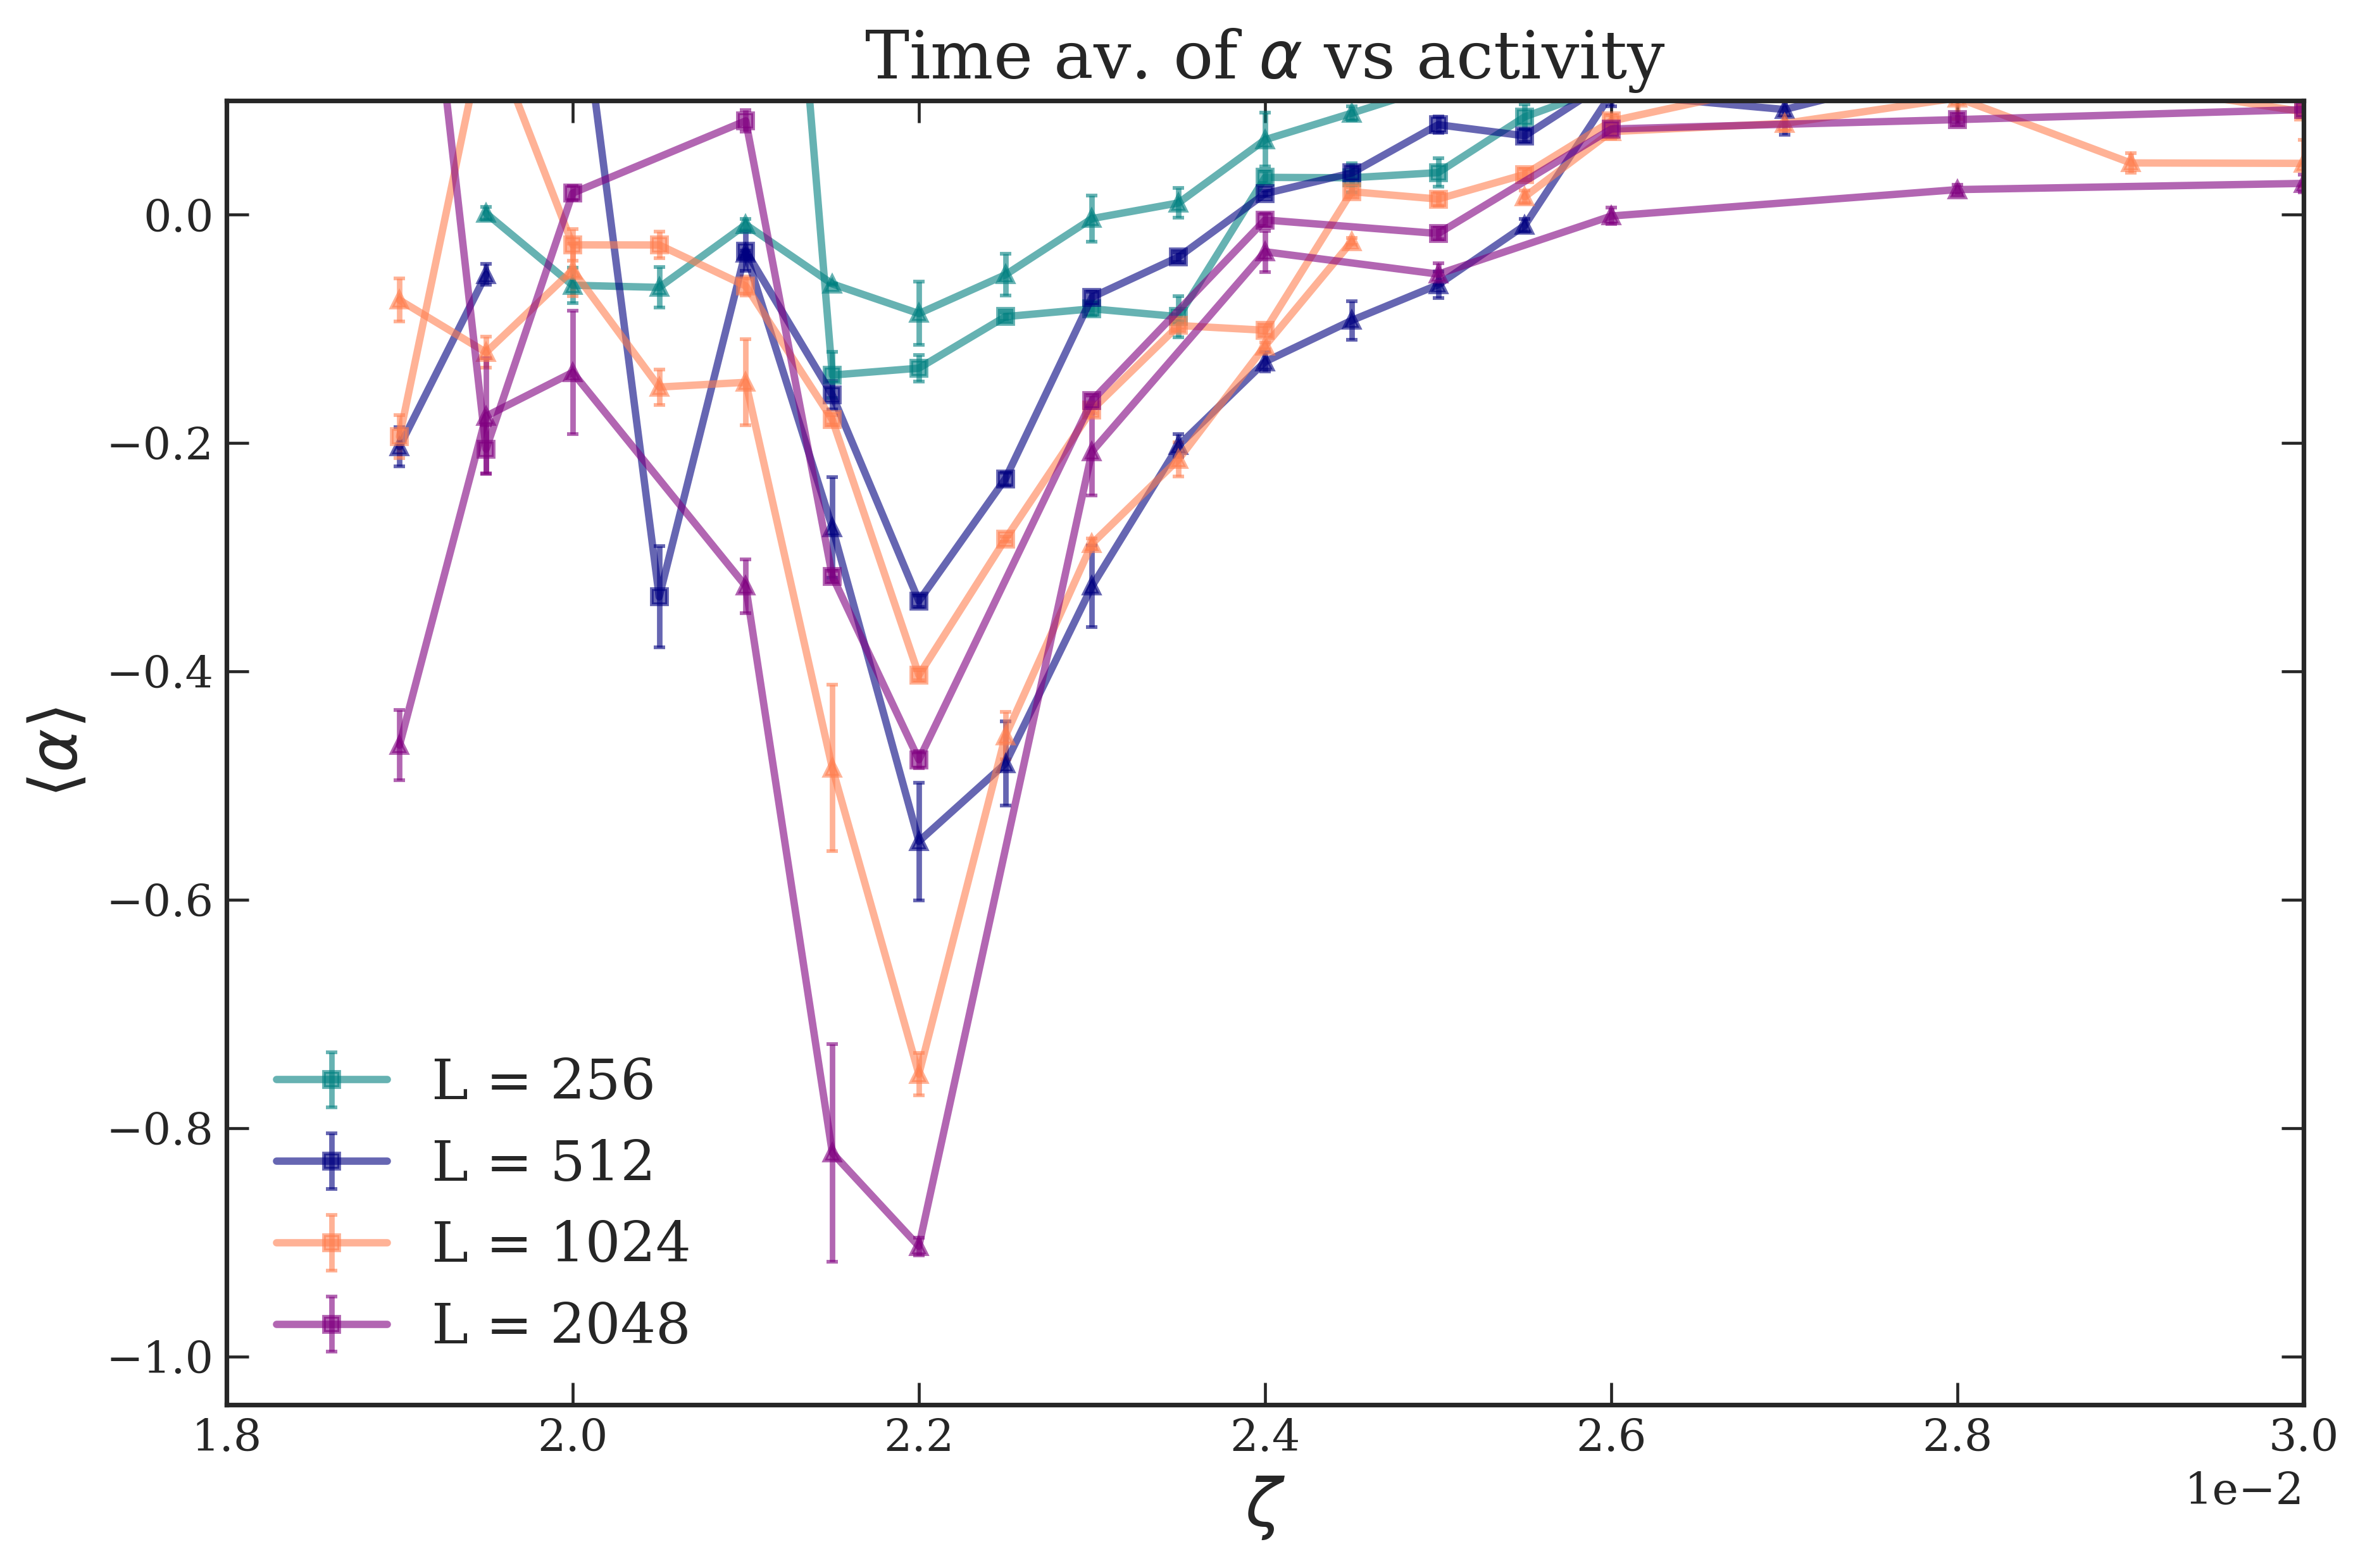

In [7]:
fig, ax = plot_alpha_mean_all(ada)
ax.set_xlim(0.018,0.03)
ax.set_ylim(ymax=.1)

In [4]:
from AnalyseDefects_dev import AnalyseDefects

def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    priority_vl = 2 if LL == 512 else 3
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = priority_vl, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3 if priority_vl == 2 else 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

LL = 1024
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

In [5]:
av_defects = ad.get_arrays_av(use_merged=True)[-1]

In [5]:
def analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,8],):
    """
    returns fit_params_time_av
    """

    def fit_func(x, alpha, beta):
                return beta + alpha * x
    param_guess = np.array([0.1, 0.1])
    fit_string = rf'$y = \beta + \alpha |k|$'
    Nparams = len(param_guess)
    Nact = sfac_av.shape[1]

    fit_params_sfac_time_av = np.zeros([Nact, 2 * Nparams]) * np.nan

    for i in range(Nact):
        try:
            x = np.log(kbins)
            y = np.log(sfac_av[:, i, 0])
            yerr = sfac_av[:, i, 1] / sfac_av[:, i, 0] 
        except:
            continue

        fit_vals = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))
        fit_err = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            for j, Npoints_to_fit in enumerate(range(Npoints_bounds[0], Npoints_bounds[1])):         
                
                fit = do_chi2_fit(fit_func, x[:Npoints_to_fit], y[:Npoints_to_fit], yerr[:Npoints_to_fit],
                                   param_guess, verbose = False)
                
                fit_vals[j] = fit.values[:] if fit._fmin.is_valid else [np.nan, np.nan]
                fit_err[j] = fit.errors[:] if fit._fmin.is_valid  else [np.nan, np.nan]
            nan_mask = np.isnan(fit_vals[:,0])
            fit_vals_valid = fit_vals[~nan_mask]
            fit_err_valid = fit_err[~nan_mask]
         #   print(i)
         #   print(fit_vals[:,0])
         #   print(fit_err[:,0])
            if len(fit_vals_valid) == 0 or len(fit_err_valid) == 0:
                continue
            alpha_weighted_av, alpha_sem = calc_weighted_mean(fit_vals_valid[:,0], fit_err_valid[:,0])
            beta_weighted_av, beta_sem = calc_weighted_mean(fit_vals_valid[:,1], fit_err_valid[:,1])
            alpha_std, beta_std = np.std(fit_vals_valid, axis = 0)
          #  print(alpha_weighted_av, np.nanmean(fit_vals_valid[:,0]))
           # print(alpha_sem, alpha_std / np.sqrt(fit_vals_valid.shape[0]))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            fit_params_sfac_time_av[i, :Nparams] = alpha_weighted_av, beta_weighted_av
            fit_params_sfac_time_av[i, Nparams:] = alpha_std / np.sqrt(fit_vals_valid.shape[0]), beta_std / np.sqrt(fit_vals_valid.shape[0]) #alpha_sem, beta_sem
   
    return fit_params_sfac_time_av


In [7]:
fit_func = lambda k, alpha, beta: np.exp(beta) * k ** (alpha)

kbins, sfac_av = ada.get_sfac(LX=LL,time_av=True)[:2]
act_list = ada.act_list[ada.LX.index(LL)]
sfac_av[:,:,-1] *= 10
fit_params_weighted7 = analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,7])



In [42]:
sfac_av.shape

(50, 30, 2)

In [34]:
corr_len_func(kbins[30], act_list[10], LL)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_15344\2104435018.py:1: RuntimeWarning: invalid value encountered in sqrt
  corr_len_func = lambda k, alpha, L: np.power(k, (-(2+alpha)/2)) * np.sqrt(np.power(2*np.pi/L, alpha) - np.power(k,alpha))


nan

In [ ]:

corr_len_func = lambda k, alpha, L: np.power(k, (-(2+alpha))) * (np.power(2*np.pi/L, alpha) - np.power(k,alpha))
#corr_len_vec = np.vectorize(lambda alpha: corr_len_func(kbins[0],alpha,LL))
for j, kval in enumerate(kbins[:4]):
    plt.plot(np.array(act_list), corr_len_func(kbins[j],fit_params_weighted7[:,0],LL), label    = f'k = {kval:.3f}')
    plt.plot(np.array(act_list), corr_len_func(kbins[j],fit_params_weighted7[:,0],(2*np.pi/sfac_av[j,:,0])), label    = f'kex = {kval:.3f}')

plt.xlim(0.018,.03)
plt.legend()

In [9]:
fit_params_weighted7.shape
corr_len = kbins[:,None] ** (-(2+fit_params_weighted7[:,0][None,:]) / 2) \
* np.sqrt((2*np.pi/LL) ** fit_params_weighted7[:,0][None,:] - kbins[:,None] ** fit_params_weighted7[:,0][None,:])

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_15344\4059729001.py:3: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt((2*np.pi/LL) ** fit_params_weighted7[:,0][None,:] - kbins[:,None] ** fit_params_weighted7[:,0][None,:])


In [13]:
corr_len.shape

(50, 30)

In [ ]:
nrows = 5
fig, ax = plt.subplots(nrows=5,figsize=(6,3*nrows))
for i, act in enumerate(act_list[:nrows]):
    ax[i].plot(kbins, corr_len[:,i], label = f'Activity = {act}')
    ax[i].legend()  

In [ ]:
fit_func = lambda k, alpha, beta: np.exp(beta) * k ** (alpha)

kbins, sfac_av = ada.get_sfac(LX=LL,time_av=True)[:2]
act_list = ada.act_list[ada.LX.index(LL)]
sfac_av[:,:,-1] *= 10
fit_params_weighted7 = analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,7])

for i, act in enumerate(act_list[:10]):
    kmax_idx = 3
    act_idx = act_list.index(act)
    fig, ax = plot_structure_factor(kbins, sfac_av[:,i,0], sfac_av[:, i,1], LX=LL)
    kvals = np.linspace(kbins[0], kbins[kmax_idx], 100)
    ax.plot(kvals, fit_func(kvals, *fit_params_weighted7[i,:2]),
             label = f'alpha = {fit_params_weighted7[i,0]:.2f} +/- {fit_params_weighted7[i,2]:.2f}, \
             beta = {np.exp(fit_params_weighted7[i,1]):.2f} +/- {np.exp(fit_params_weighted7[i,1])*fit_params_weighted7[i,3]:.2f}')
   # ax.fill_between(kvals,
    #             fit_func(kvals, fit_params_weighted7[i,0] + fit_params_weighted7[i,2], fit_params_weighted7[i,1]-fit_params_weighted7[i,3]), fit_func(kvals, fit_params_weighted7[i,0] - fit_params_weighted7[i,2], fit_params_weighted7[i,1]+ fit_params_weighted7[i,3]), alpha = 0.3)
    ax.set_xlim(xmax=0.2)
    ax.set_title(f'Activity = {act}')
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.legend() 
    plt.show()  


In [ ]:
kbins, sfac_av = ada.get_sfac(LX=LX,time_av=True)[:2]
sfac_av[:,:,-1] *= 12
act_idx = 0
plt.errorbar(kbins, sfac_av[:,act_idx,0], yerr = sfac_av[:,act_idx,1], fmt = 'o')
plt.xscale('log')
plt.yscale('log')

In [ ]:
LX = 2048
save_path = ada.inputs_paths[ada.LX.index(LX)]
act_idx_bounds=[0, 10]
act_list = ada.act_list[ada.LX.index(LX)][act_idx_bounds[0]:act_idx_bounds[1]]

kbins, sfac_av = ada.get_sfac(LX=LX,time_av=True)[:2]

sfac_av

fit_params_weighted8 = analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,8])
fit_params_weighted7 = analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,7])


fit_params = ada.get_alpha(LX = LX,)[1][act_idx_bounds[0]:act_idx_bounds[-1],:]
scaling_exp_list = ada.get_alpha(LX = LX,)[1][act_idx_bounds[0]:act_idx_bounds[-1],0]
scaling_exp_error = ada.get_alpha(LX = LX,)[1][act_idx_bounds[0]:act_idx_bounds[-1],2]
scaling_label_list = [rf'$\alpha = {scaling_exp:.2f}$' for scaling_exp in scaling_exp_list]   

nrows = int(len(act_list)/2)
fig, ax = plt.subplots(nrows = nrows, ncols=2, figsize=(14, 5*nrows ))
ax = ax.flatten()
for i, act in enumerate(act_list):
    act_idx = ada.act_list[ada.LX.index(LX)].index(act)

    if np.isnan(sfac_av[0, act_idx, 0]):
        continue
    

    axx = ada.plot_sfac_per_activity(LX = LX, Npoints_to_fit=5,scaling_exp_list = [scaling_exp_list[i]], scaling_label_list=[scaling_label_list[i]], act_list=[act], ax = ax[i])
    axx.set_title(f'Activity = {act}')

    axx.plot(kbins, fit_params[i,2] * kbins ** scaling_exp_list[i], '--', label = rf'$Fit (\alpha = {scaling_exp_list[i]:.2f}$)', alpha=0.5,)

    axx.set_xlim([kbins[0]/2, kbins[-1]])
    axx.set_ylim([0.3, np.nanmax(sfac_av[0, act_idx, 0]*1.5)])
    for Npoints_to_fit, scaling_exp, label in zip([6,7], \
            [fit_params_weighted7[act_idx,0], fit_params_weighted8[act_idx,0]], [rf'$\alpha = {fit_params_weighted7[act_idx,0]:.2f}$', rf'$\alpha = {fit_params_weighted8[act_idx,0]:.2f}$']):
        k_begin_lines_idx = Npoints_to_fit - 1
        x = kbins[:Npoints_to_fit]
        axx.plot(x, sfac_av[k_begin_lines_idx, act_idx, 0] * x**scaling_exp / x[-1]**scaling_exp, '--', label = label, alpha=0.5,) 
    axx.legend()
fig.savefig(os.path.join(save_path, 'figs\\sfac_per_activity_all2.png'), dpi = 420, pad_inches=0.25)



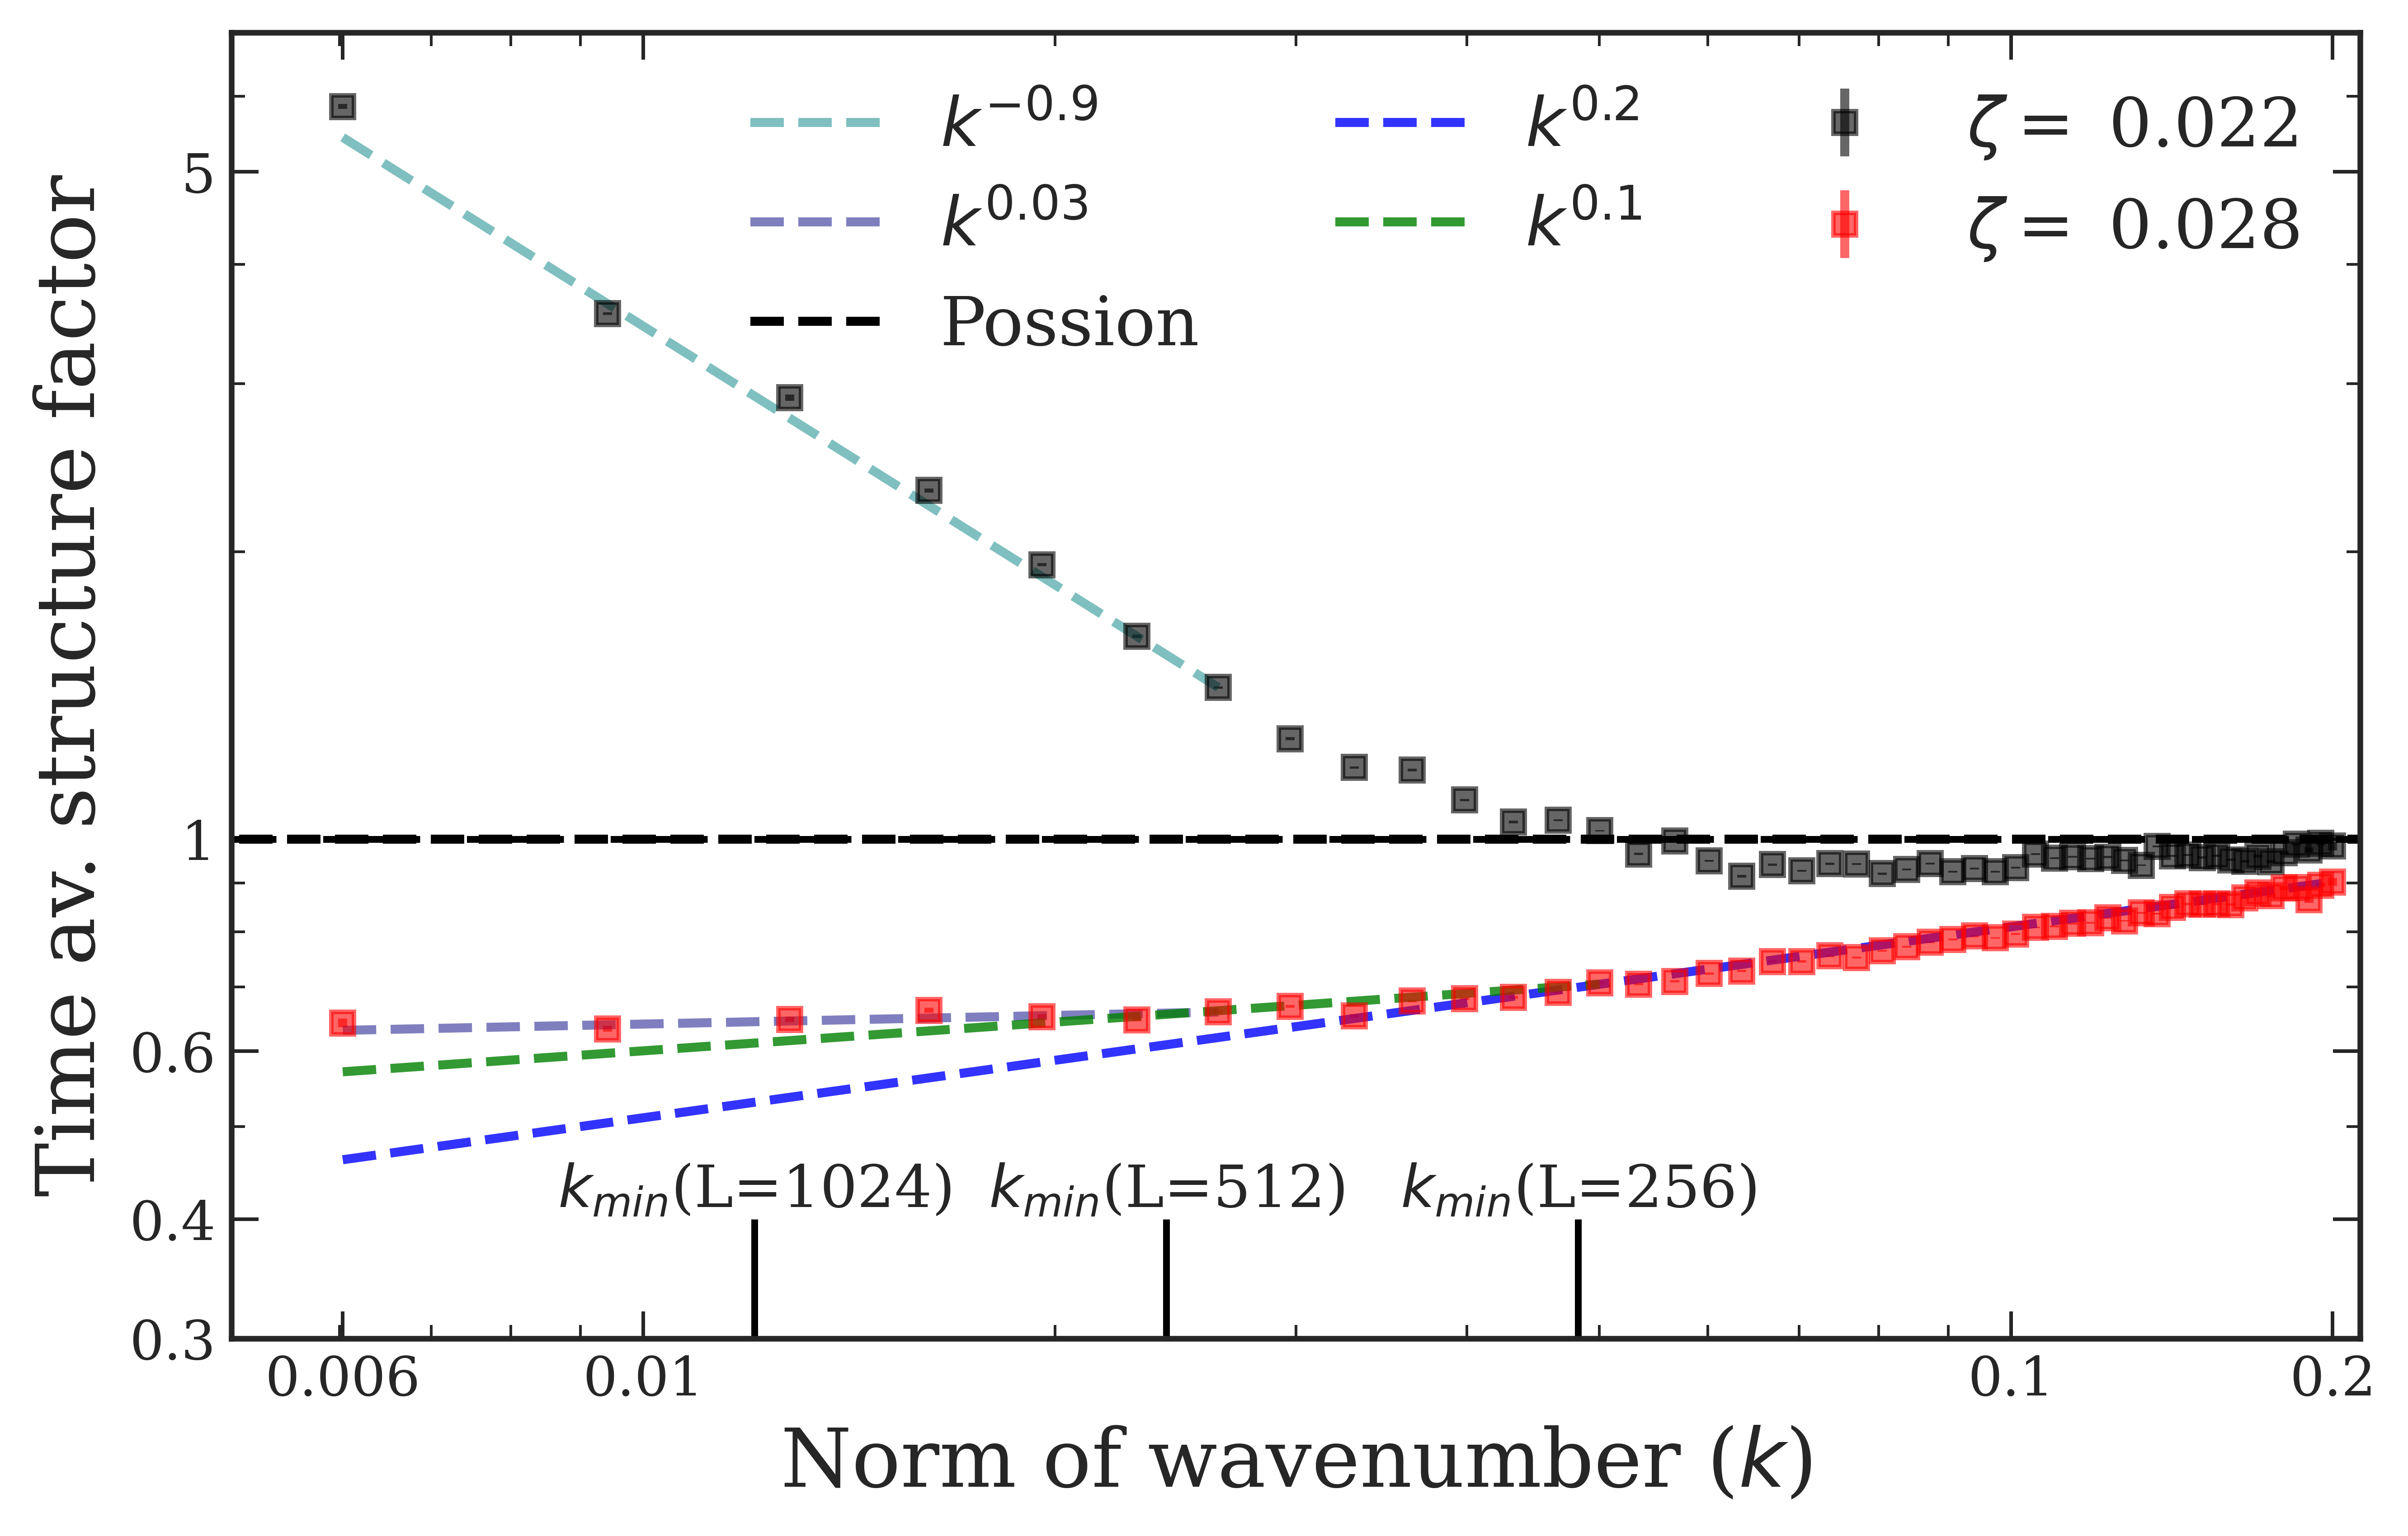

In [138]:
#kmin_list is the smallest k for each L
kmin_list = []
for L in adaa.LX:
    kbins = ada.get_sfac(LX=L,time_av=True)[0]
    kmin_list.append(np.min(kbins))


ratio = 4.5 / 7
w = 7.5
h = w * ratio
fig, ax = plt.subplots(ncols=1,figsize=(w, h))
label_list = [r'$k^{-0.9}$', r'$k^{0.03}$']
scaling_exp_list = [float(label.split('{')[-1].split('}')[0]) for label in label_list]
axx = ada.plot_sfac_per_activity(LX = 2048, Npoints_to_fit=7, act_list=[0.022,0.028,], scaling_exp_list = scaling_exp_list, scaling_label_list=label_list, ax = ax)#act_list = [0.022, 0.024, 0.026, 0.027], weighted = True)
kbins, sfac_av = ada.get_sfac(LX=2048)[:2]

axx.hlines(1, 0, 0.4, color = 'k', linestyle='--', lw=1.5)
axx.set_ylim([0.3, 7])
axx.set_xlim([0.005,0.18])
axx.legend(loc='upper right', ncol=2)
klabel_list = [r'$k_{min}$(L=256)', r'$k_{min}$(L=512)', r'$k_{min}$(L=1024)']
for i, kmin in enumerate(kmin_list[:-1]):
    axx.vlines(kmin, 0.3, .4, color = 'k', linestyle='-', lw=1.5)
    axx.text(kmin, 0.4, klabel_list[i], fontsize=13, verticalalignment='bottom', horizontalalignment='center')
#axx.text(0.7, 0.2, r'L = 1024', transform=axx.transAxes, fontsize=16, verticalalignment='top', fontweight='normal')
#axx.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))

act_idx = ada.act_list[ada.LX.index(2048)].index(0.028)
x = kbins[0:50]
x2 = kbins[0:14]
scaling_exp = .2
scaling_exp2 = .1
axx.plot(x, (sfac_av[-1,act_idx,0]-0.00) * x**scaling_exp / x[-1]**scaling_exp, '--',lw=2, alpha=.8,label=r'$k^{0.2}$', color='blue')
axx.plot(x2, (sfac_av[len(x2),act_idx,0]+0.0) * x2**scaling_exp2 / x2[-1]**scaling_exp2, '--',lw=2, alpha=.8,label=r'$k^{0.1}$', color='green')
axx.legend(ncol=3)
fig.dpi = 720


In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 4.5)) 
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

act_max = 0.022
normalize_sus = False

xmin = 0.37
ymin = 0.08
width = 0.3

axinn = ax.inset_axes([0.31, 0.25,width,2.3*width])

ax1_xlims = [0.013, 0.1005]
xticks = np.round(np.linspace(ax1_xlims[0], ax1_xlims[1], 5), 2)
ax.set(xticks=xticks,xticklabels=xticks, xlim=ax1_xlims,)

axinn_xlims = [0.0175, 0.0265]
axinn_ylims = [-.25, 10]
axinn_xticks = [1.8e-2, 2.2e-2,2.6e-2]
axinn_yticks = np.round(np.linspace(axinn_ylims[0]+.1, axinn_ylims[1] -.1,3)).astype('int')
axinn.set(xticks=axinn_xticks, yticks=axinn_yticks, xticklabels=axinn_xticks, yticklabels=axinn_yticks, xlim=axinn_xlims, ylim=axinn_ylims)
ax.indicate_inset_zoom(axinn)  

for N, act_list in enumerate(ada.act_list):

    sus = ada.get_binder_susceptibility(ada.LX[N])[1]
    act_max_idx = act_list.index(act_max)

    if normalize_sus:    
        sus = sus / sus[act_max_idx].max()

    label = f'L = {ada.LX[N]}'
    ax.plot(act_list, sus[:,0], f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, label = label)
    axinn.plot(act_list, sus[:,0], f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4,)

ax.set_xlabel('Activity')
ax.set_ylabel('Response function')
axinn.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw=1.5, alpha=.7, linestyle = '--')
ax.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7, label = r'$\zeta=0.022$')
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))
axinn.yaxis.set_minor_locator(ticker.MultipleLocator(1))
axinn.xaxis.set_minor_locator(ticker.MultipleLocator(1e-3))
#axinn.legend()
ax.legend()
fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/nematic_analysis_all/susceptibility.eps', dpi = 720, pad_inches = .5)

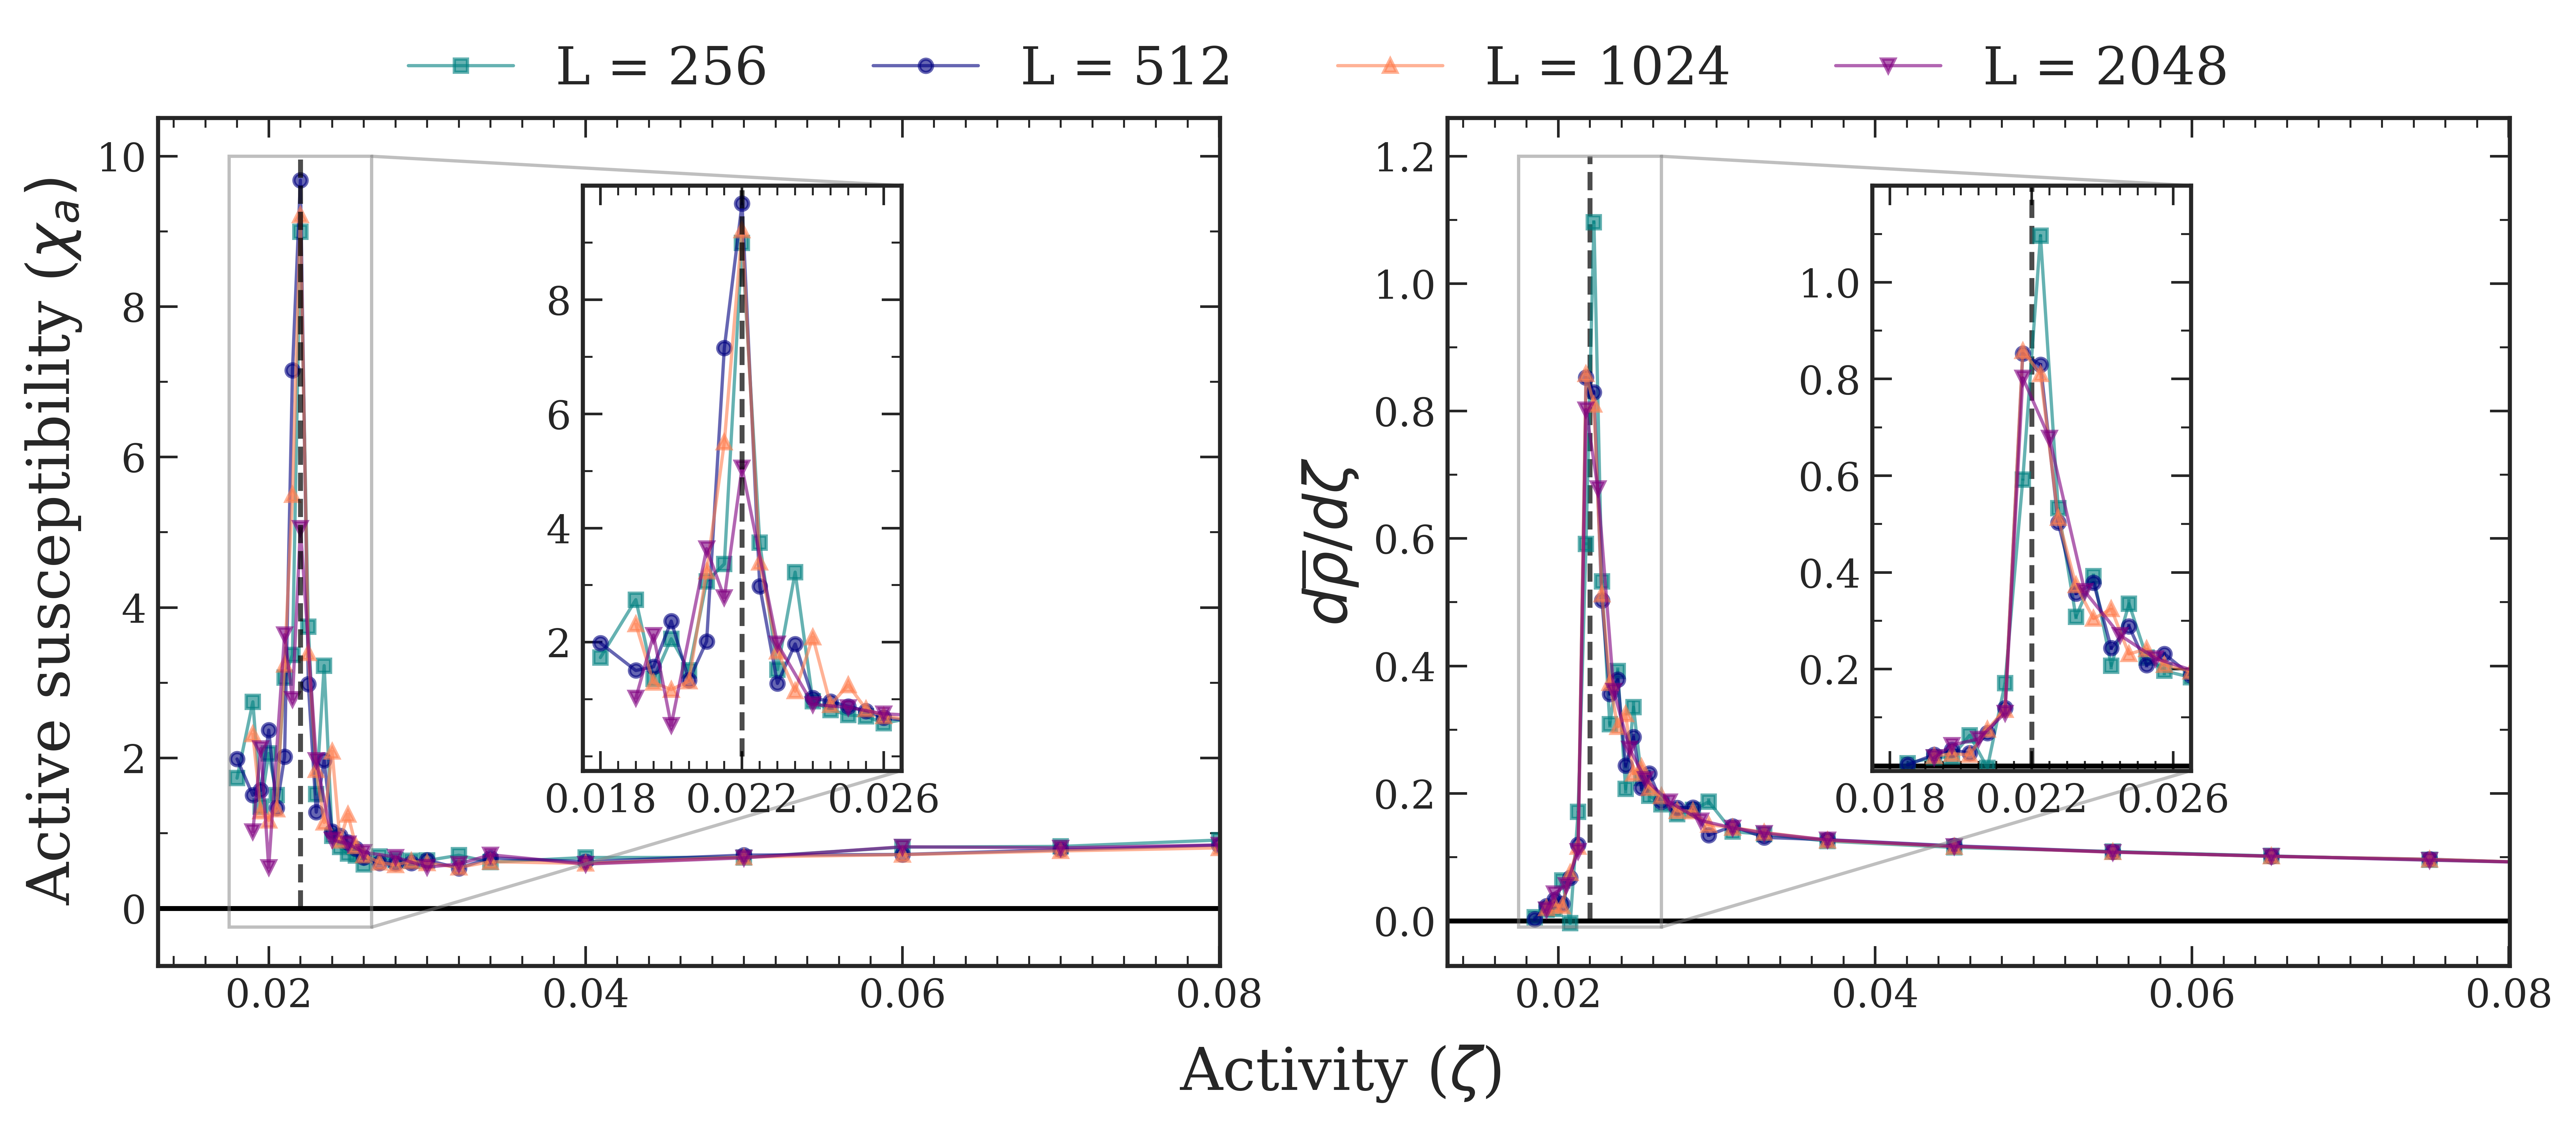

In [33]:

fig, ax0 = plt.subplots(nrows = 1, ncols = 2, figsize=(11,4.5)) 
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
ax0 = ax0.flatten()
ax = ax0[0]
axx = ax0[1]
act_max = 0.022
normalize_sus = False

xmin = 0.37
ymin = 0.08
width = 0.3

inset_box = [0.4, 0.23,width,2.3*width]
axinn = ax.inset_axes(inset_box)
axinn2 = axx.inset_axes(inset_box)

axinn_xlims = [0.0175, 0.0265]
axinn_ylims = [-.25, 10]
axinn2_ylims = [-.01,1.2]
axinn_xticks = [1.8e-2, 2.2e-2,2.6e-2]
ax1_xlims = [0.013, 0.08005]
axinn_yticks = np.round(np.linspace(2, 8, 4)).astype('int')
axinn2_yticks = np.round(np.linspace(0.2,1,5), 1)
axinn.set(xticks=axinn_xticks, yticks=axinn_yticks, xticklabels=axinn_xticks, yticklabels=axinn_yticks, xlim=axinn_xlims, ylim=axinn_ylims)
ax.indicate_inset_zoom(axinn) 

axinn2.set(xticks=axinn_xticks, yticks=axinn2_yticks, xticklabels=axinn_xticks, yticklabels=axinn2_yticks, xlim=axinn_xlims, ylim=axinn2_ylims)
axx.indicate_inset_zoom(axinn2)

xticks = np.round(np.linspace(0.02, 0.1, 5), 2)
for akse in ax0:
    akse.set(xticks=xticks,xticklabels=xticks, xlim=ax1_xlims,)
    akse.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))




for N, act_list in enumerate(ada.act_list):

    sus = ada.get_susceptibility(ada.LX[N])
    act_max_idx = act_list.index(act_max)

    if normalize_sus:    
        sus = sus / sus[act_max_idx].max()

    label = f'L = {ada.LX[N]}'
    ax.plot(act_list, sus[:,0], f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, label = label)
    axinn.plot(act_list, sus[:,0], f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4,)

#ax.set_xlabel(r'Activity ($\zeta$)')
ax.set_ylabel(r'Active susceptibility ($\chi_a)$')
axinn.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw=1.5, alpha=.7, linestyle = '--')
ax.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
axx.vlines(act_max, 0, axinn2_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
axinn2.vlines(act_max, 0, axinn2_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))
axx.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
axinn.yaxis.set_minor_locator(ticker.MultipleLocator(1))
axinn.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))
axinn2.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))
axinn2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
#axinn.legend()
#ax.legend()

marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

act_max = 0.022
for N, act_list in enumerate(ada.act_list):

    sus = ada.get_susceptibility(ada.LX[N])
    av_def = ada.get_av_defects(ada.LX[N])
    av_def_err = av_def[:,1]
    av_def = av_def[:,0]
    act_max_idx = act_list.index(act_max)

    av_def_diff = np.diff(av_def) #/ ada.LX[N]**2    

   # print(len(av_def), len(np.diff(av_def)) )
    act_shift = (np.array(act_list) - act_max) / act_max
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff 
    d_av_def = av_def_diff / act_diff #np.diff(av_def) / np.diff(act_list) #/ ada.LX[N]**2
    err_d_av_def = np.sqrt(av_def_err[1:]**2 + av_def_err[:-1]**2) / act_diff
    label = f'L = {ada.LX[N]}'
    #ax.plot(act_shift, sus[:,0], f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, label = label)
    #axx.plot(act_diff_tot, d_av_def, f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)#, label = label)
    axx.errorbar(np.array(act_list[:-1]) + act_diff/2 , d_av_def, yerr=err_d_av_def, fmt =  f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)#, label = label)
    axinn2.errorbar(np.array(act_list[:-1]) + act_diff/2 , d_av_def, yerr=err_d_av_def, fmt =f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)#, label = label)
    #axinn2.plot(act_diff_tot, d_av_def, f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4,)# label = label)

axx.hlines(0, 0, 0.1, color = 'k', linestyle='-', lw=1.5)
ax.hlines(0, 0, 0.1, color = 'k', linestyle='-', lw = 1.5)
axinn2.hlines(0, 0, 0.1, color = 'k', linestyle='-', lw=1.5)    
#axx.set_xlim(ax1_xlims)
#axx.set(xticks=ax)
axx.set_ylabel(r'$d \overline{\rho} / d \zeta$')
fig.supxlabel(r'Activity ($\zeta$)',x=0.52, y=0.04)
fig.legend(ncol=8, fontsize = 16, bbox_to_anchor=(0.88, 1.08))
fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/nematic_analysis_all/susceptibility.eps', dpi = 720, pad_inches = .5)

In [ ]:

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 4.5)) 
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

act_max = 0.022
normalize_sus = False

xmin = 0.37
ymin = 0.08
width = 0.3

axinn = ax.inset_axes([0.31, 0.25,width,2.3*width])

ax1_xlims = [0.013, 0.1005]
xticks = np.round(np.linspace(ax1_xlims[0], ax1_xlims[1], 5), 2)
ax.set(xticks=xticks,xticklabels=xticks, xlim=ax1_xlims,)

axinn_xlims = [0.0175, 0.0265]
axinn_ylims = [-.25, 10]
axinn_xticks = [1.8e-2, 2.2e-2,2.6e-2]
axinn_yticks = np.round(np.linspace(axinn_ylims[0]+.1, axinn_ylims[1] -.1,3)).astype('int')
axinn.set(xticks=axinn_xticks, yticks=axinn_yticks, xticklabels=axinn_xticks, yticklabels=axinn_yticks, xlim=axinn_xlims, ylim=axinn_ylims)
ax.indicate_inset_zoom(axinn)  

for N, act_list in enumerate(ada.act_list):

    sus = ada.get_susceptibility(ada.LX[N])
    act_max_idx = act_list.index(act_max)

    if normalize_sus:    
        sus = sus / sus[act_max_idx].max()

    label = f'L = {ada.LX[N]}'
    ax.plot(act_list, sus[:,0], f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, label = label)
    axinn.plot(act_list, sus[:,0], f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4,)

ax.set_xlabel(r'Activity ($\zeta$)')
ax.set_ylabel('Susceptibility ($\chi$)')
axinn.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw=1.5, alpha=.7, linestyle = '--')
ax.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))
axinn.yaxis.set_minor_locator(ticker.MultipleLocator(1))
axinn.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))
#axinn.legend()
ax.legend()
fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/nematic_analysis_all/susceptibility.eps', dpi = 720, pad_inches = .5)


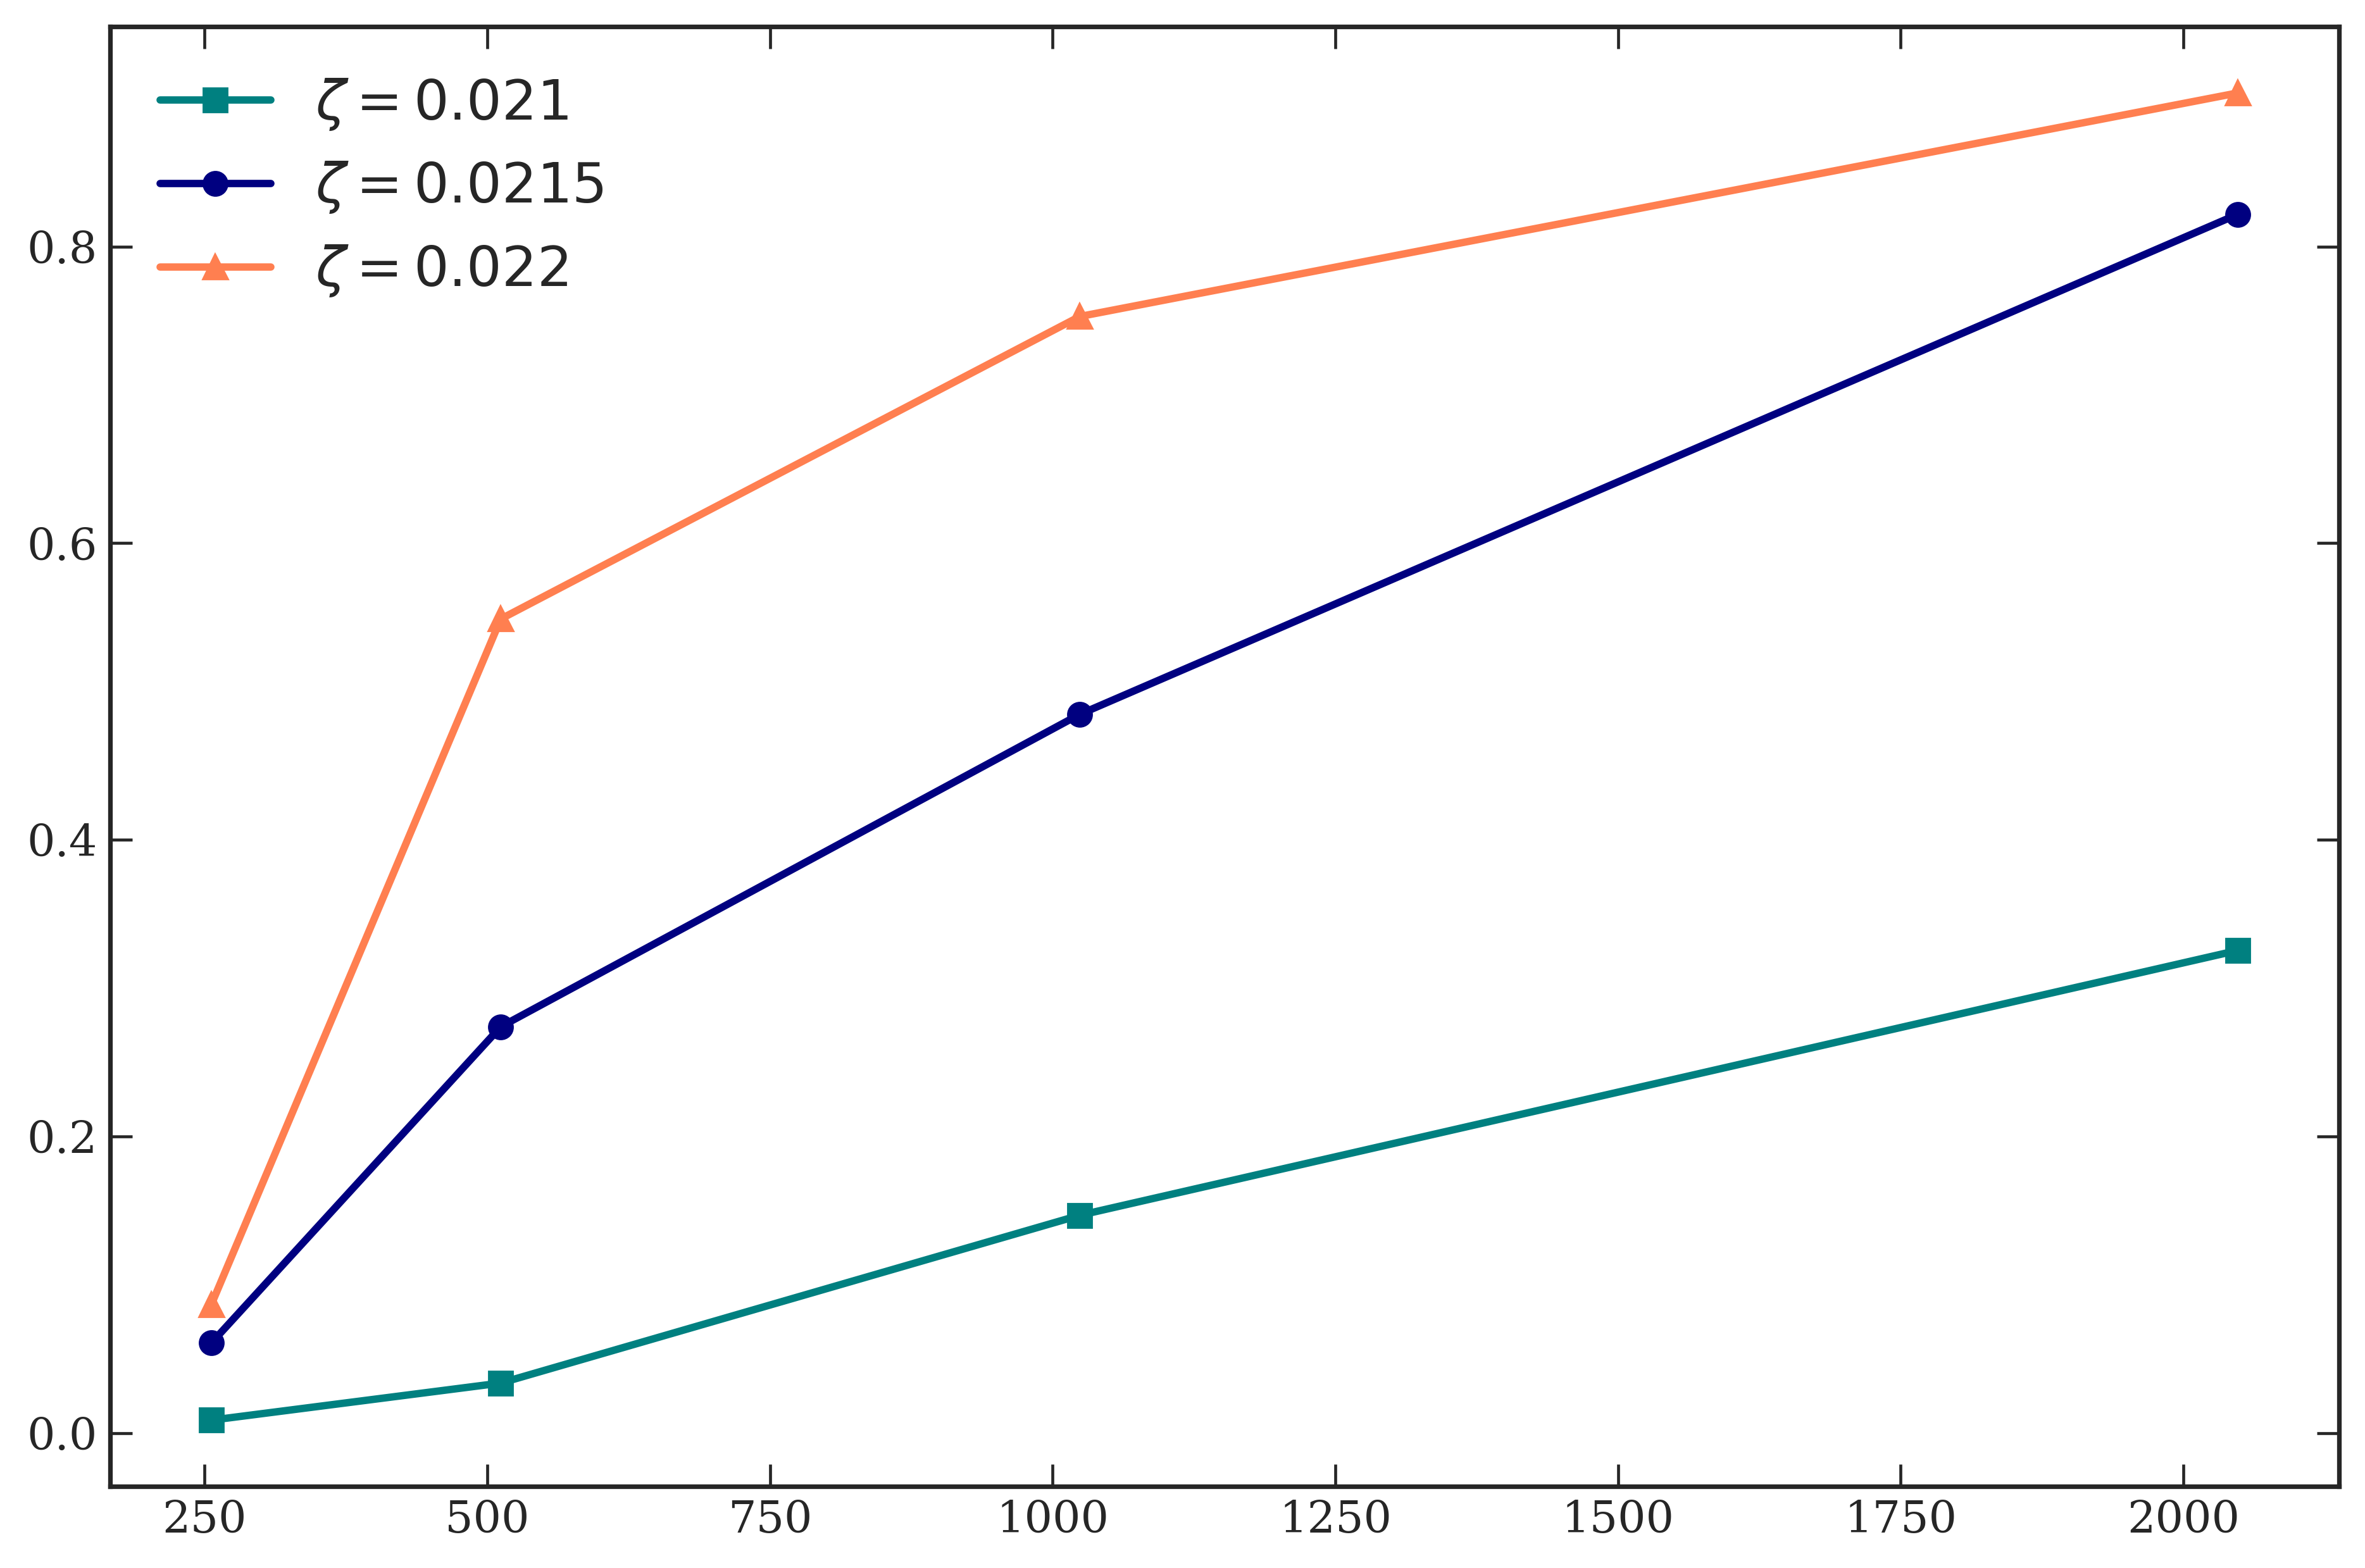

In [6]:
av_of_fits, fit_params_of_av = ada.get_alpha(LX=2048)
fit_of_av = fit_params_of_av[:,[0,2]]
act_list = ada.act_list[ada.LX.index(2048)]

fig, ax = plt.subplots(figsize=(9, 6))
acts_to_plot = [0.021, 0.0215, 0.022]
alphas = np.zeros([len(acts_to_plot), len(ada.LX)])
for i, L in enumerate(ada.LX):
    act_list = ada.act_list[i]
    act_idx_list = [act_list.index(act) for act in acts_to_plot]
    av_of_fits, fit_params_of_av = ada.get_alpha(LX=L)
    alphas[:,i] = fit_params_of_av[act_idx_list, [0]]
ax.plot(ada.LX, -alphas[0], 's-', label = rf'$\zeta = {acts_to_plot[0]}$')
ax.plot(ada.LX, -alphas[1], 'o-', label = rf'$\zeta = {acts_to_plot[1]}$')
ax.plot(ada.LX, -alphas[2], '^-', label = rf'$\zeta = {acts_to_plot[2]}$')
ax.legend()

True
2 2.638091851381591 0.26739029051420704
0.6507854834150593 +/- 0.12204255414291763
-0.9002898112631668 +/- 0.03418717205506398


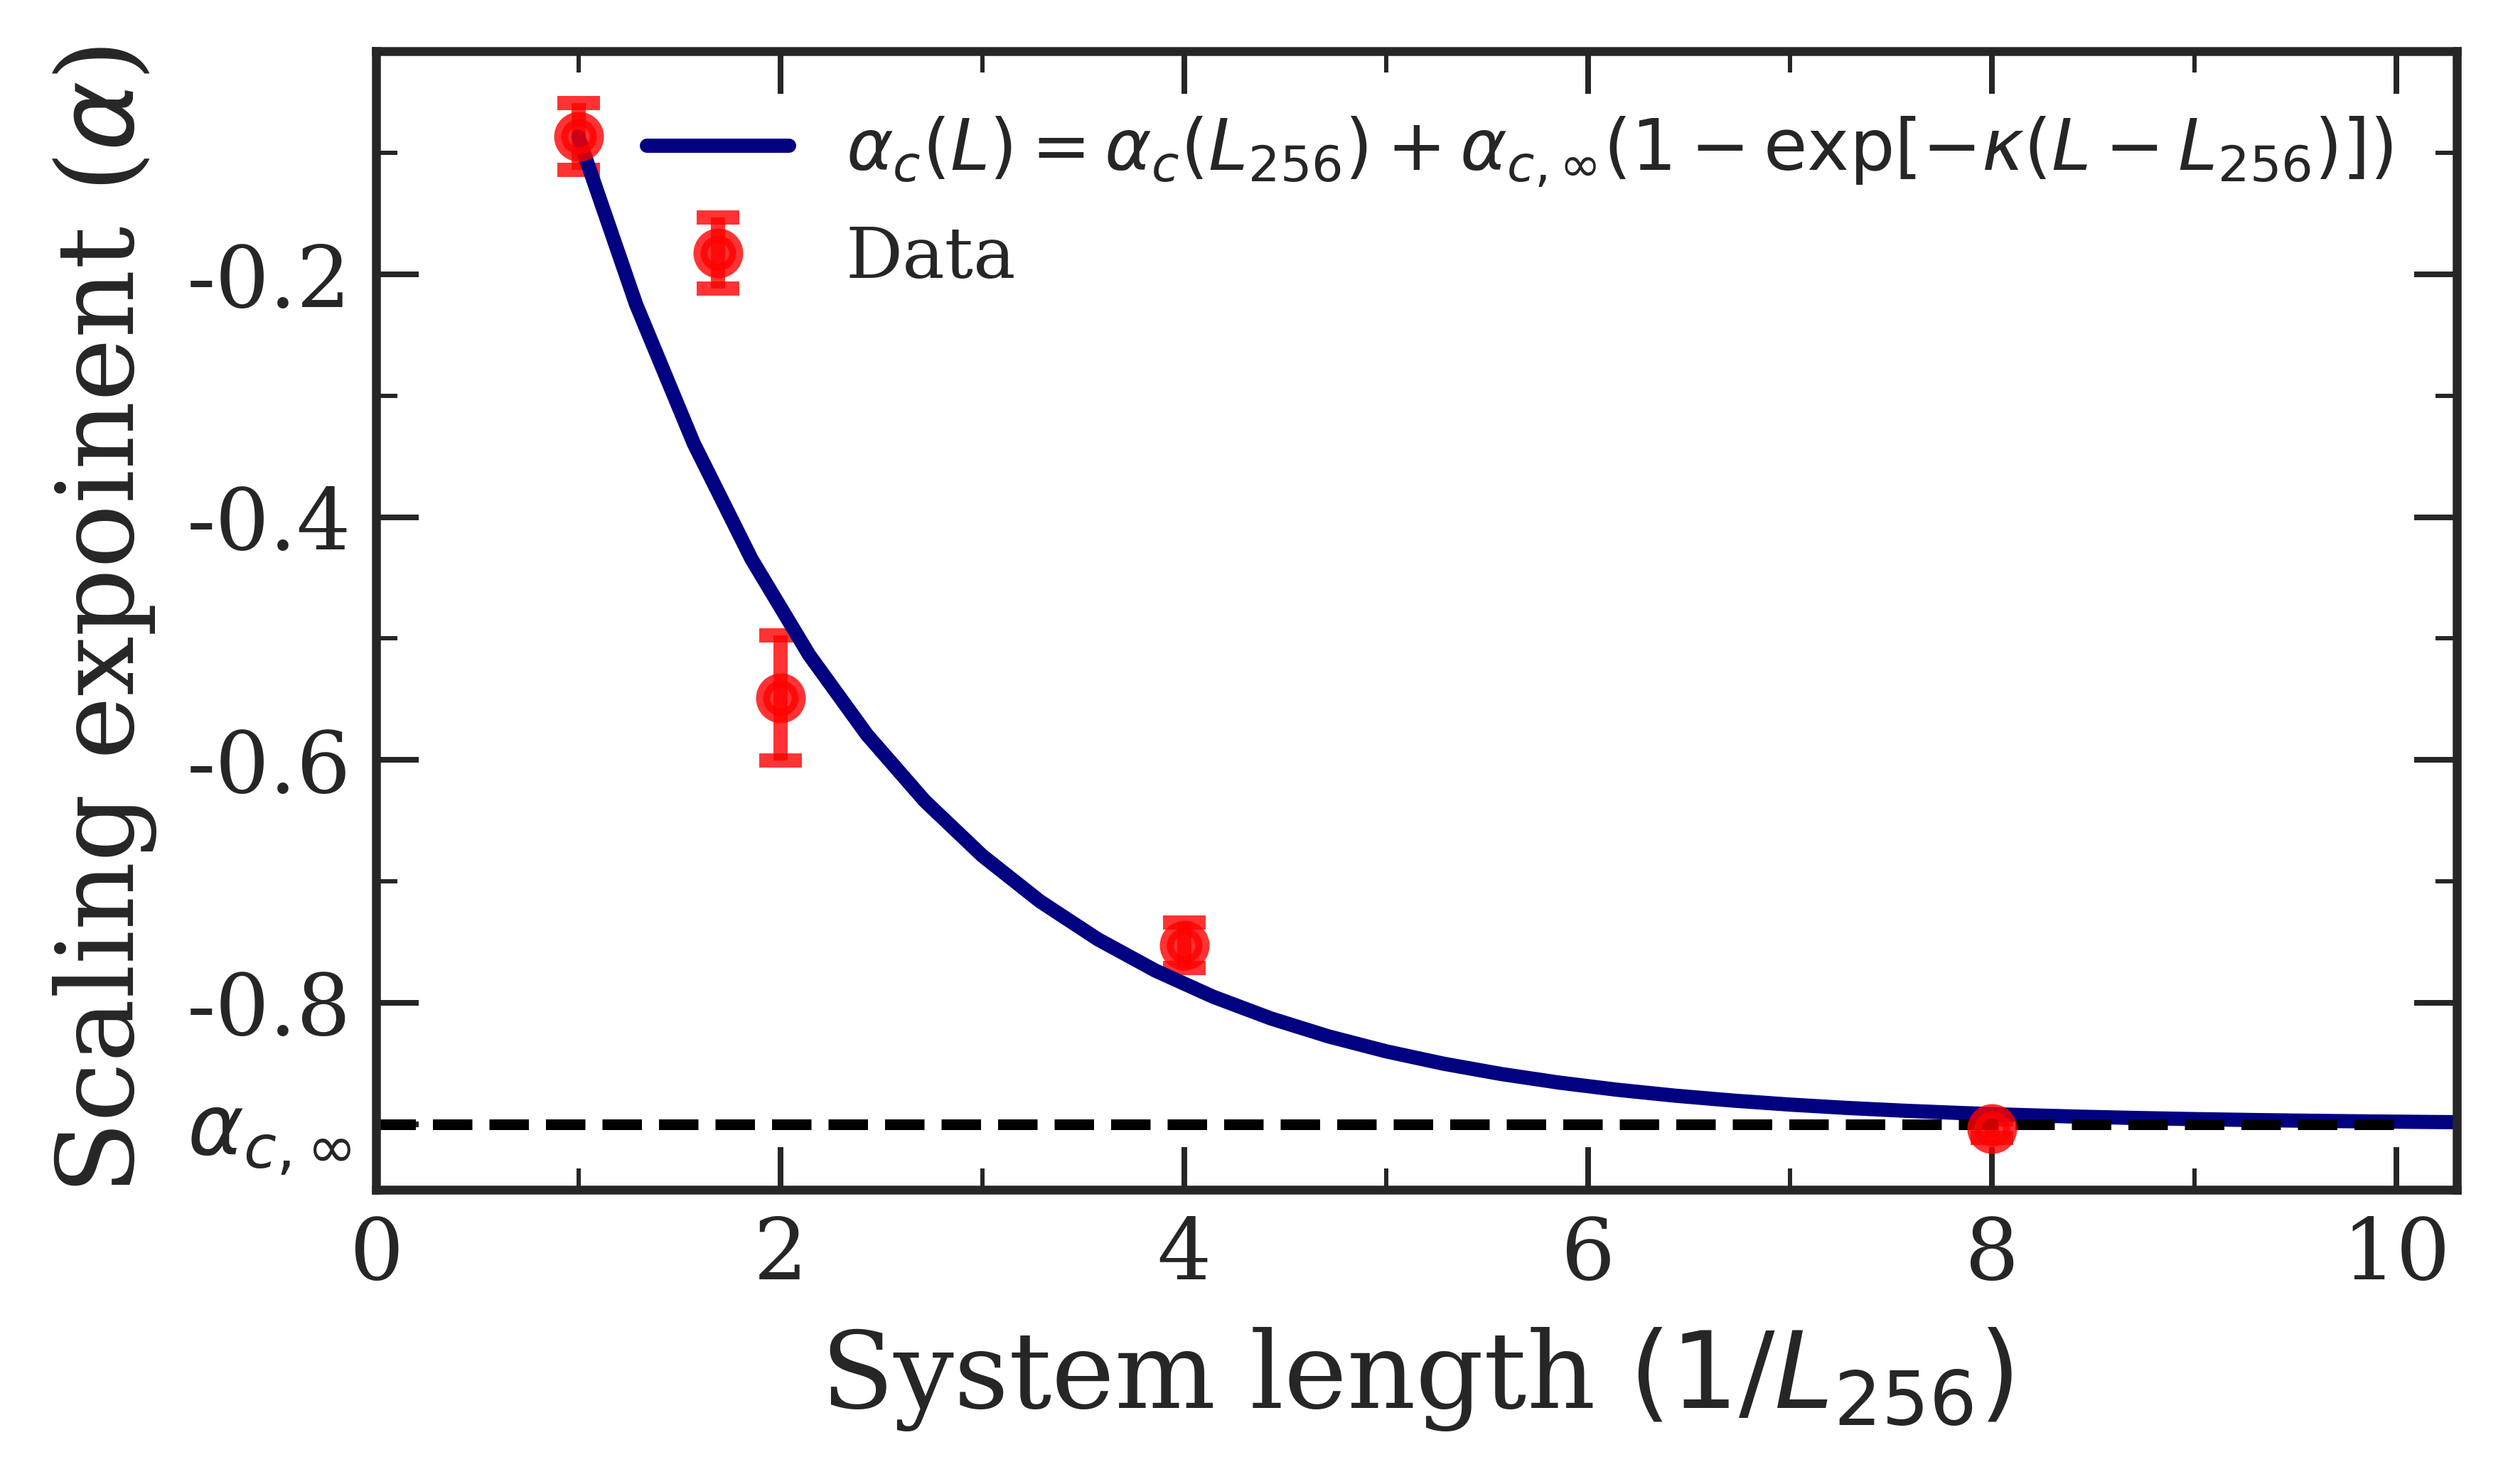

In [31]:

from scipy.interpolate import CubicSpline

av_of_fits, fit_params_of_av = ada.get_alpha(LX=2048)
fit_of_av = fit_params_of_av[:,[0,2]]
act_list = ada.act_list[ada.LX.index(2048)]

fig, ax = plt.subplots(figsize=(5,3))
min_syst_idx = 0
acts_to_plot = [0.0215, 0.022]
alphas = np.zeros([len(acts_to_plot), len(ada.LX[min_syst_idx:])])
alphas_err = np.zeros([len(acts_to_plot), len(ada.LX[min_syst_idx:])])
LX_list = ada.LX[min_syst_idx:]
for i, L in enumerate(ada.LX[min_syst_idx:]):
    act_list = ada.act_list[i+min_syst_idx]
    act_idx_list = [act_list.index(act) for act in acts_to_plot]
    av_of_fits, fit_params_of_av = ada.get_alpha(LX=L)
    alphas[:,i] = fit_params_of_av[act_idx_list,0] 
    alphas_err[:,i] = fit_params_of_av[act_idx_list,2]
norm = np.ones(4-min_syst_idx)#[1,1,1] #np.abs(alphas[:,0])
normx = LX_list[0]
LX_list_normed = [LX_list[i] / normx for i in range(4-min_syst_idx)]

X = np.array(LX_list_normed)
Y = np.array(list(alphas[1]/norm[1]))
dY = np.array(list(alphas_err[1]/norm[1]))
cs = CubicSpline(X,Y, bc_type='natural')
x = np.linspace(1,8,8)
y = cs(x)
dy = np.zeros_like(y)
data_idx = [2, 4,5, 7]
dy[[0, 1, 3, 7]] = dY
zero_mask = (dy == 0)
dy[zero_mask] = np.mean(dy[~zero_mask])


ax.errorbar(X, Y, dY, fmt = 'o', label = rf'Data', color = 'red',\
        markersize = 5, alpha = .8, elinewidth = 2, capsize = 3, markeredgewidth = 2)

x0 = 0.9

fit_func_exp = lambda x, k, c: c * (1 - np.exp(-k*(x-1)))
fit_label = r'$\alpha_c(L) = \alpha_c(L_{256}) + \alpha_{c,\infty}(1 - \exp[-\kappa(L - L_{256})])$'

param_guess = [.5, -1,]
point_bounds = [50,250]

x_plot_fit = np.linspace(X[0],15,50)
fit_exp = do_chi2_fit(fit_func_exp, X, Y - Y[0], np.sqrt(dY**2 + dY[0]**2), param_guess, verbose = False)
print(fit_exp._fmin.is_valid)

yticks = [fit_exp.values['c'] + Y[0], -0.8, -0.6, -0.4, -0.2]
yticklabels = [r'$\alpha_{c,\infty}$', -0.8, -0.6, -0.4, -0.2]
ax.set_xlabel(r'System length $(1/L_{256})$', fontsize=15)
ax.set_ylabel(r'Scaling expoinent ($\alpha$)', fontsize=15)
ax.plot(x_plot_fit, fit_func_exp(x_plot_fit, *fit_exp.values[:]) + Y[0], '-', color = 'navy', label = fit_label)
ax.legend(fontsize=10)
ax.set(yticks = yticks, yticklabels = yticklabels, xlim=[0,10.3])
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.hlines(fit_exp.values['c'] + Y[0], 0,10, lw=1.5,color = 'black', linestyle = '--', label = rf'$\alpha_c = {(fit_exp.values["c"]+Y[0]):.2f}$')
Ndof, chi2, prop = get_statistics_from_fit(fit_exp, len(X),)
print(Ndof, chi2, prop)
fig.tight_layout()
fig.dpi = 720

print(fit_exp.values['k'], "+/-", fit_exp.errors['k'])  
print(fit_exp.values['c'] + Y[0], "+/-", fit_exp.errors['c'])
#print(fit_exp.values['L0'], "+/-", fit_exp.errors['L0'])

C:\Users\Simon Andersen\Projects\Projects\Appstat2022\External_Functions\ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


True
1 4.334334766330768 0.037351008946094125
0.5660654224990601 +/- 0.05538956458428879
-0.9180496247796284 +/- 0.011464723631931734
0.8032820998668306 +/- 0.0667171944082873


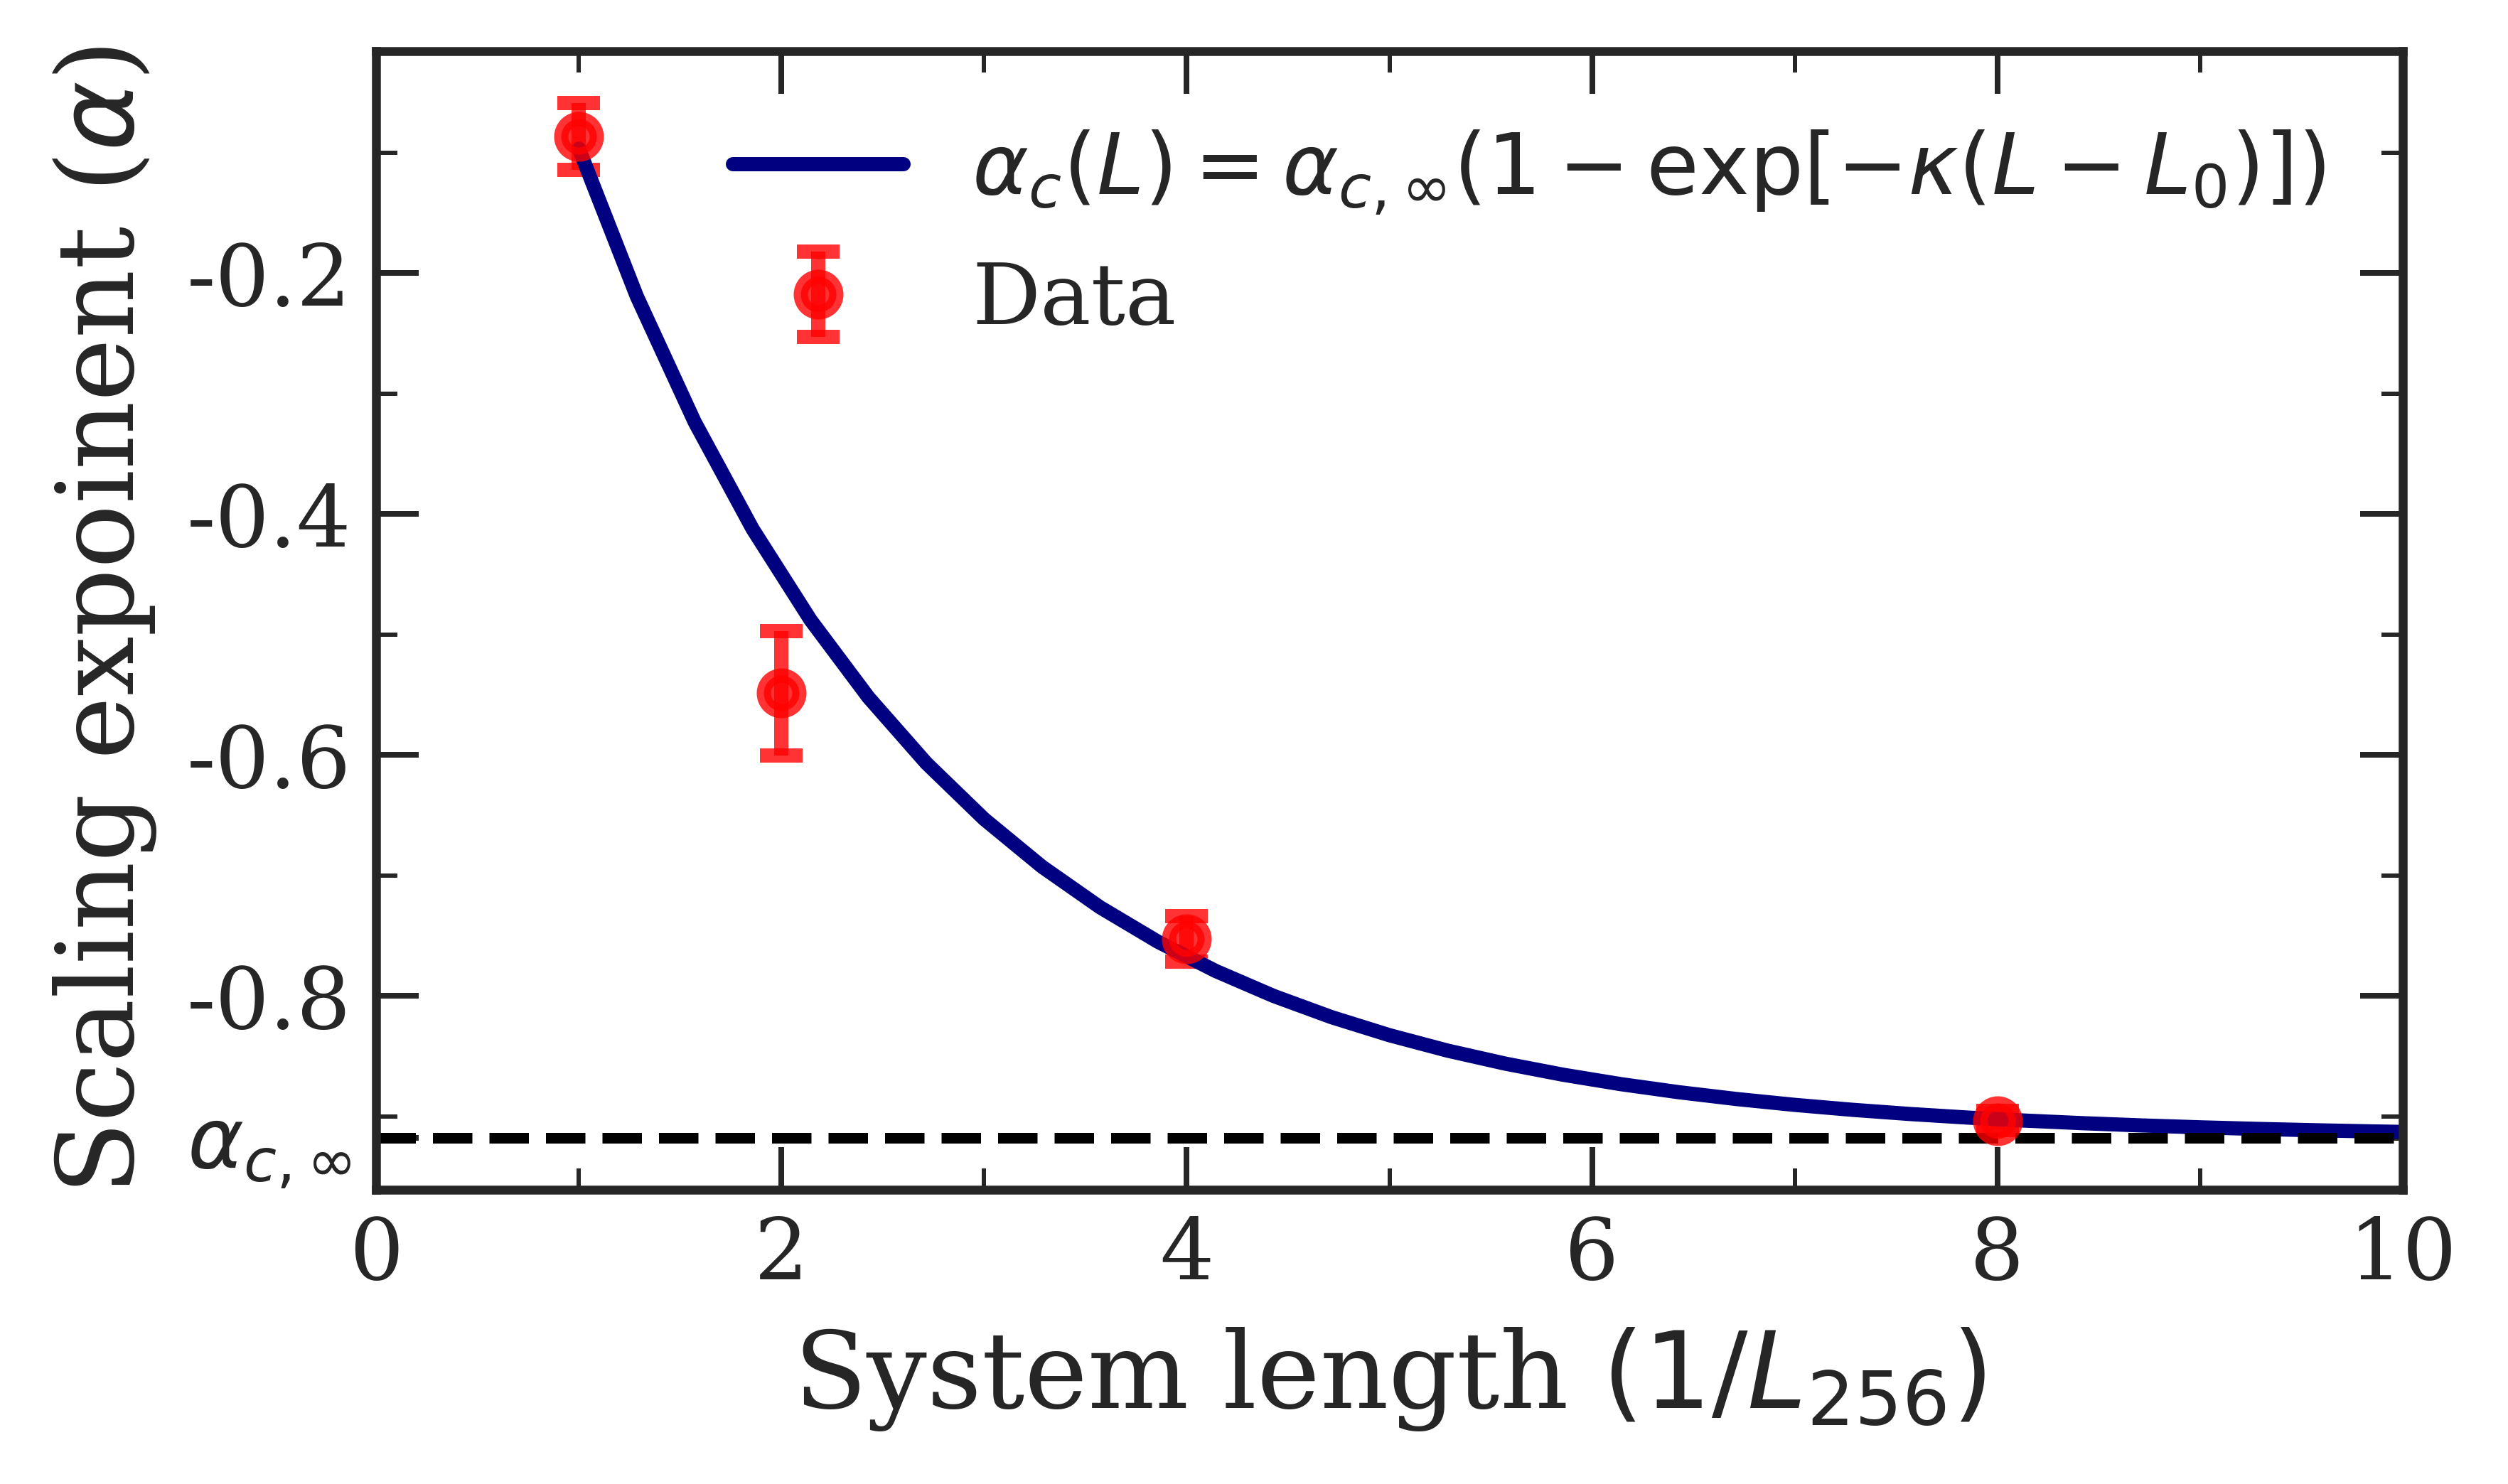

In [16]:

from scipy.interpolate import CubicSpline

av_of_fits, fit_params_of_av = ada.get_alpha(LX=2048)
fit_of_av = fit_params_of_av[:,[0,2]]
act_list = ada.act_list[ada.LX.index(2048)]

fig, ax = plt.subplots(figsize=(5,3))
min_syst_idx = 0
acts_to_plot = [0.0215, 0.022]
alphas = np.zeros([len(acts_to_plot), len(ada.LX[min_syst_idx:])])
alphas_err = np.zeros([len(acts_to_plot), len(ada.LX[min_syst_idx:])])
LX_list = ada.LX[min_syst_idx:]
for i, L in enumerate(ada.LX[min_syst_idx:]):
    act_list = ada.act_list[i+min_syst_idx]
    act_idx_list = [act_list.index(act) for act in acts_to_plot]
    av_of_fits, fit_params_of_av = ada.get_alpha(LX=L)
    alphas[:,i] = fit_params_of_av[act_idx_list,0] 
    alphas_err[:,i] = fit_params_of_av[act_idx_list,2]
norm = np.ones(4-min_syst_idx)#[1,1,1] #np.abs(alphas[:,0])
normx = LX_list[0]
LX_list_normed = [LX_list[i] / normx for i in range(4-min_syst_idx)]

X = np.array(LX_list_normed)
Y = np.array(list(alphas[1]/norm[1]))
dY = np.array(list(alphas_err[1]/norm[1]))
cs = CubicSpline(X,Y, bc_type='natural')
x = np.linspace(1,8,8)
y = cs(x)
dy = np.zeros_like(y)
data_idx = [2, 4,5, 7]
dy[[0, 1, 3, 7]] = dY
zero_mask = (dy == 0)
dy[zero_mask] = np.mean(dy[~zero_mask])


ax.errorbar(X, Y, dY, fmt = 'o', label = rf'Data', color = 'red',\
        markersize = 5, alpha = .8, elinewidth = 2, capsize = 3, markeredgewidth = 2)

x0 = 0.9

fit_func_exp = lambda x, k, c, L0: c * (1 - np.exp(-k*(x-L0)))
fit_label = r'$\alpha_c(L) = \alpha_{c,\infty}(1 - \exp[-\kappa(L-L_0)])$'

param_guess = [.5, -1, 0.9]
point_bounds = [50,250]

x_plot_fit = np.linspace(X[0],15,50)
fit_exp = do_chi2_fit(fit_func_exp, X, Y, dY, param_guess, verbose = False)
print(fit_exp._fmin.is_valid)

yticks = [fit_exp.values['c'], -0.8, -0.6, -0.4, -0.2]
yticklabels = [r'$\alpha_{c,\infty}$', -0.8, -0.6, -0.4, -0.2]
ax.set_xlabel(r'System length $(1/L_{256})$', fontsize=15)
ax.set_ylabel(r'Scaling expoinent ($\alpha$)', fontsize=15)
ax.plot(x_plot_fit, fit_func_exp(x_plot_fit, *fit_exp.values[:]), '-', color = 'navy', label = fit_label)
ax.legend(fontsize=12)
ax.set(yticks = yticks, yticklabels = yticklabels, xlim=[0,10])
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.hlines(fit_exp.values['c'], 0,10, lw=1.5,color = 'black', linestyle = '--', label = rf'$\alpha_c = {fit_exp.values["c"]:.2f}$')
Ndof, chi2, prop = get_statistics_from_fit(fit_exp, len(X),)
print(Ndof, chi2, prop)
fig.tight_layout()
fig.dpi = 720

print(fit_exp.values['k'], "+/-", fit_exp.errors['k'])  
print(fit_exp.values['c'], "+/-", fit_exp.errors['c'])
print(fit_exp.values['L0'], "+/-", fit_exp.errors['L0'])


In [12]:
for i, L in enumerate(ada.LX):
    act_list = ada.act_list[i]
    alpha_vals = ada.get_alpha(LX=L,)[1]

    act = 0.022
    act_idx = act_list.index(act)
    print(f'Activity = {act}', alpha_vals[act_idx,0], alpha_vals[act_idx,2])


Activity = 0.022 -0.0865147865911898 0.027714249498622518
Activity = 0.022 -0.5488872713239336 0.051594012437089276
Activity = 0.022 -0.7528584750719259 0.018736038750658202
Activity = 0.022 -0.9036032912924843 0.007802683228237715


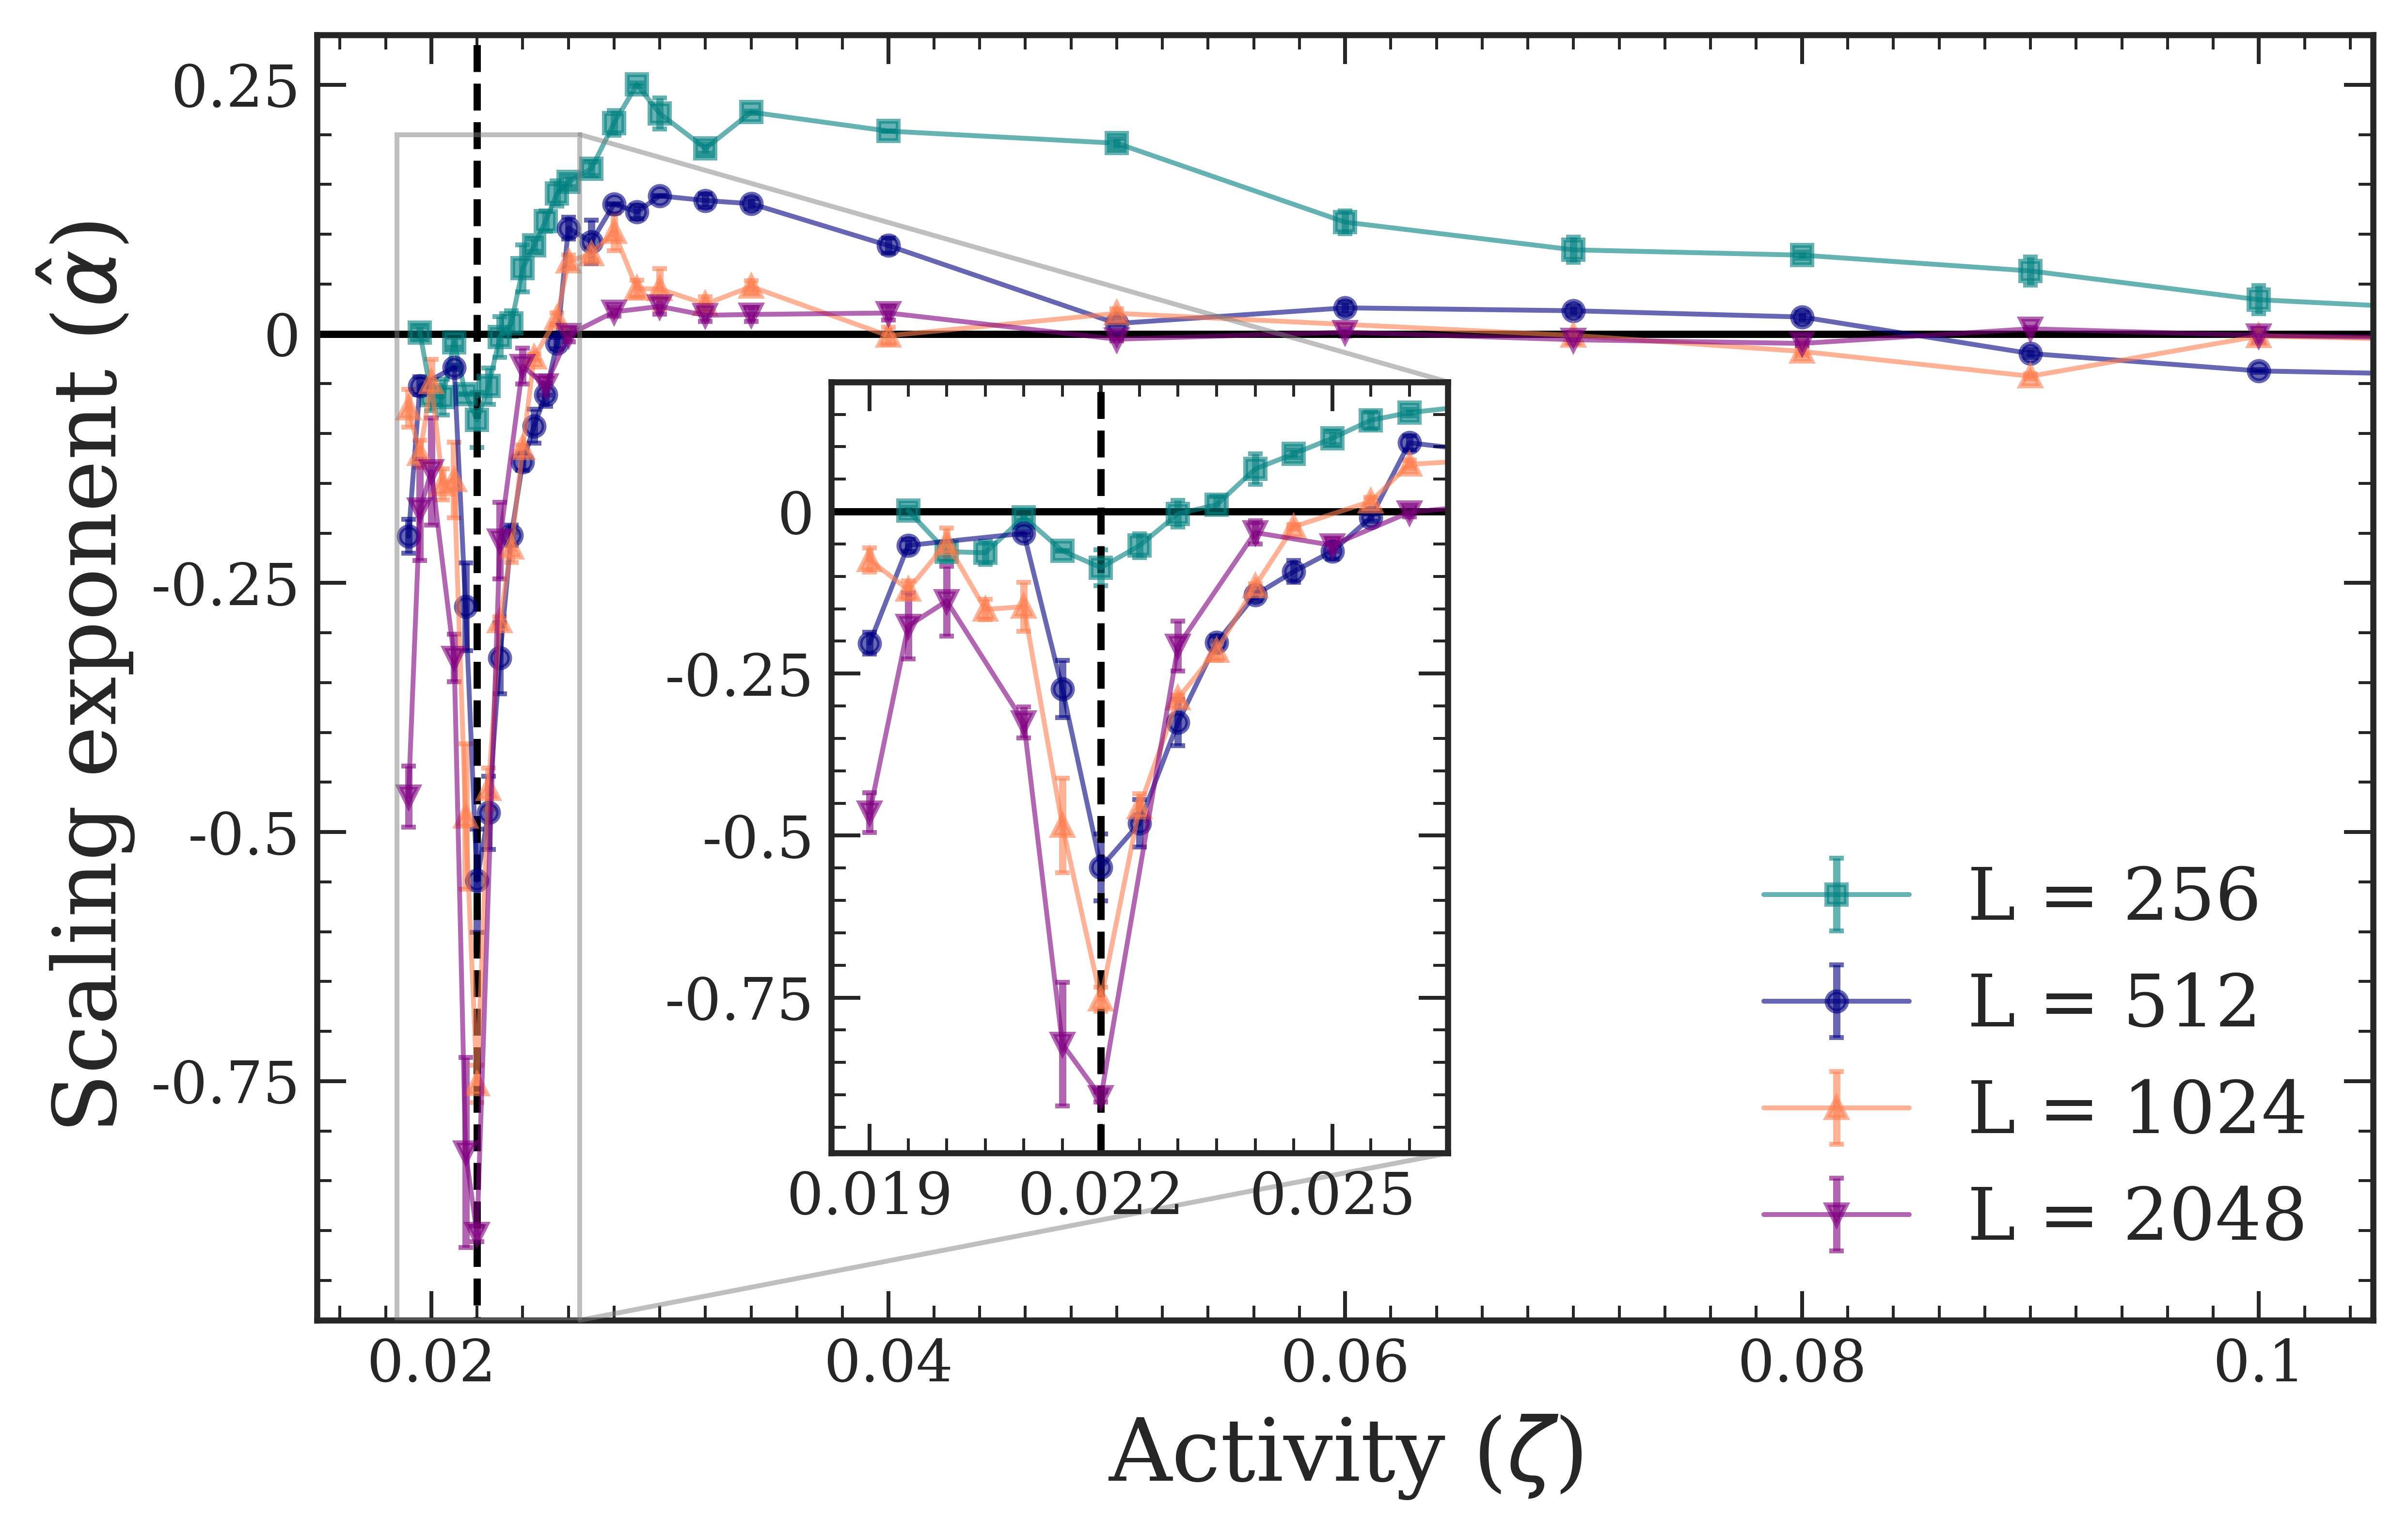

In [8]:

fig, ax = plt.subplots(figsize=(7, 4.5)) 

peak1 = 0.022
peak2 = 0.028

xmin = 0.25
ymin = 0.13
width = 0.3
inset_box = [xmin, ymin,1*width,2*width]

plot_fit_of_time_av = True
ax1, axin1 = ada.plot_alpha_mean_sfac(time_av=plot_fit_of_time_av,  ax = ax, inset_box = inset_box)


ax1_xlims = [0.015, 0.105]
ax1_ylims = [-.99, 0.3]
axin1_xlims = [0.0185, 0.0265] #[0.019, 0.035]
axin1_ylims = [ax1_ylims[0], .2] #[-.82, 0.3]


yticks = [-1.25, -1, -.75, -.5, -.25, 0, 0.25, 0.5]
axin1_yticks =  [-1.25, -1, -.75, -.5, -.25, 0, 0.25,]
xticks = np.round(np.linspace(ax1_xlims[0], ax1_xlims[1], 5), 2)
axin1_xticks = np.round(np.linspace(axin1_xlims[0]+0.001, axin1_xlims[1] - 0.001,3), 3)
axin1_xticks = [0.019, 0.022, 0.025]
ax1.set(xticks=xticks, yticks=yticks, xticklabels=xticks, yticklabels=yticks, xlim=ax1_xlims, ylim=ax1_ylims)
axin1.set(xticks=axin1_xticks, yticks=axin1_yticks, xticklabels=axin1_xticks, yticklabels=axin1_yticks, xlim=axin1_xlims, ylim=axin1_ylims)

ax1.vlines(peak1, -2, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
axin1.vlines(peak1, -2, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
#ax1.vlines(peak2, -1, 1, color = 'r', lw = 1.5, linestyle = '--', alpha = 1)
#axin1.vlines(peak2, -1, 1, color = 'r', lw = 1.5, linestyle = '--', alpha = 1)
ax1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '-', alpha = 1)
axin1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '-', alpha = 1)
ax1.indicate_inset_zoom(axin1,)
ax1.set_ylabel(r'Scaling exponent ($\hat{\alpha}$)', labelpad=3)

ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))
axin1.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
axin1.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))


ax.legend()
ax1.set_xlabel(r'Activity ($\zeta$)')
fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/hyperuniformity.png', dpi = 420, pad_inches = .5)
#fig.legend(ncol=8, fontsize = 16, bbox_to_anchor=(0.84, 1.025))

#axin1.vlines(peak2, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)

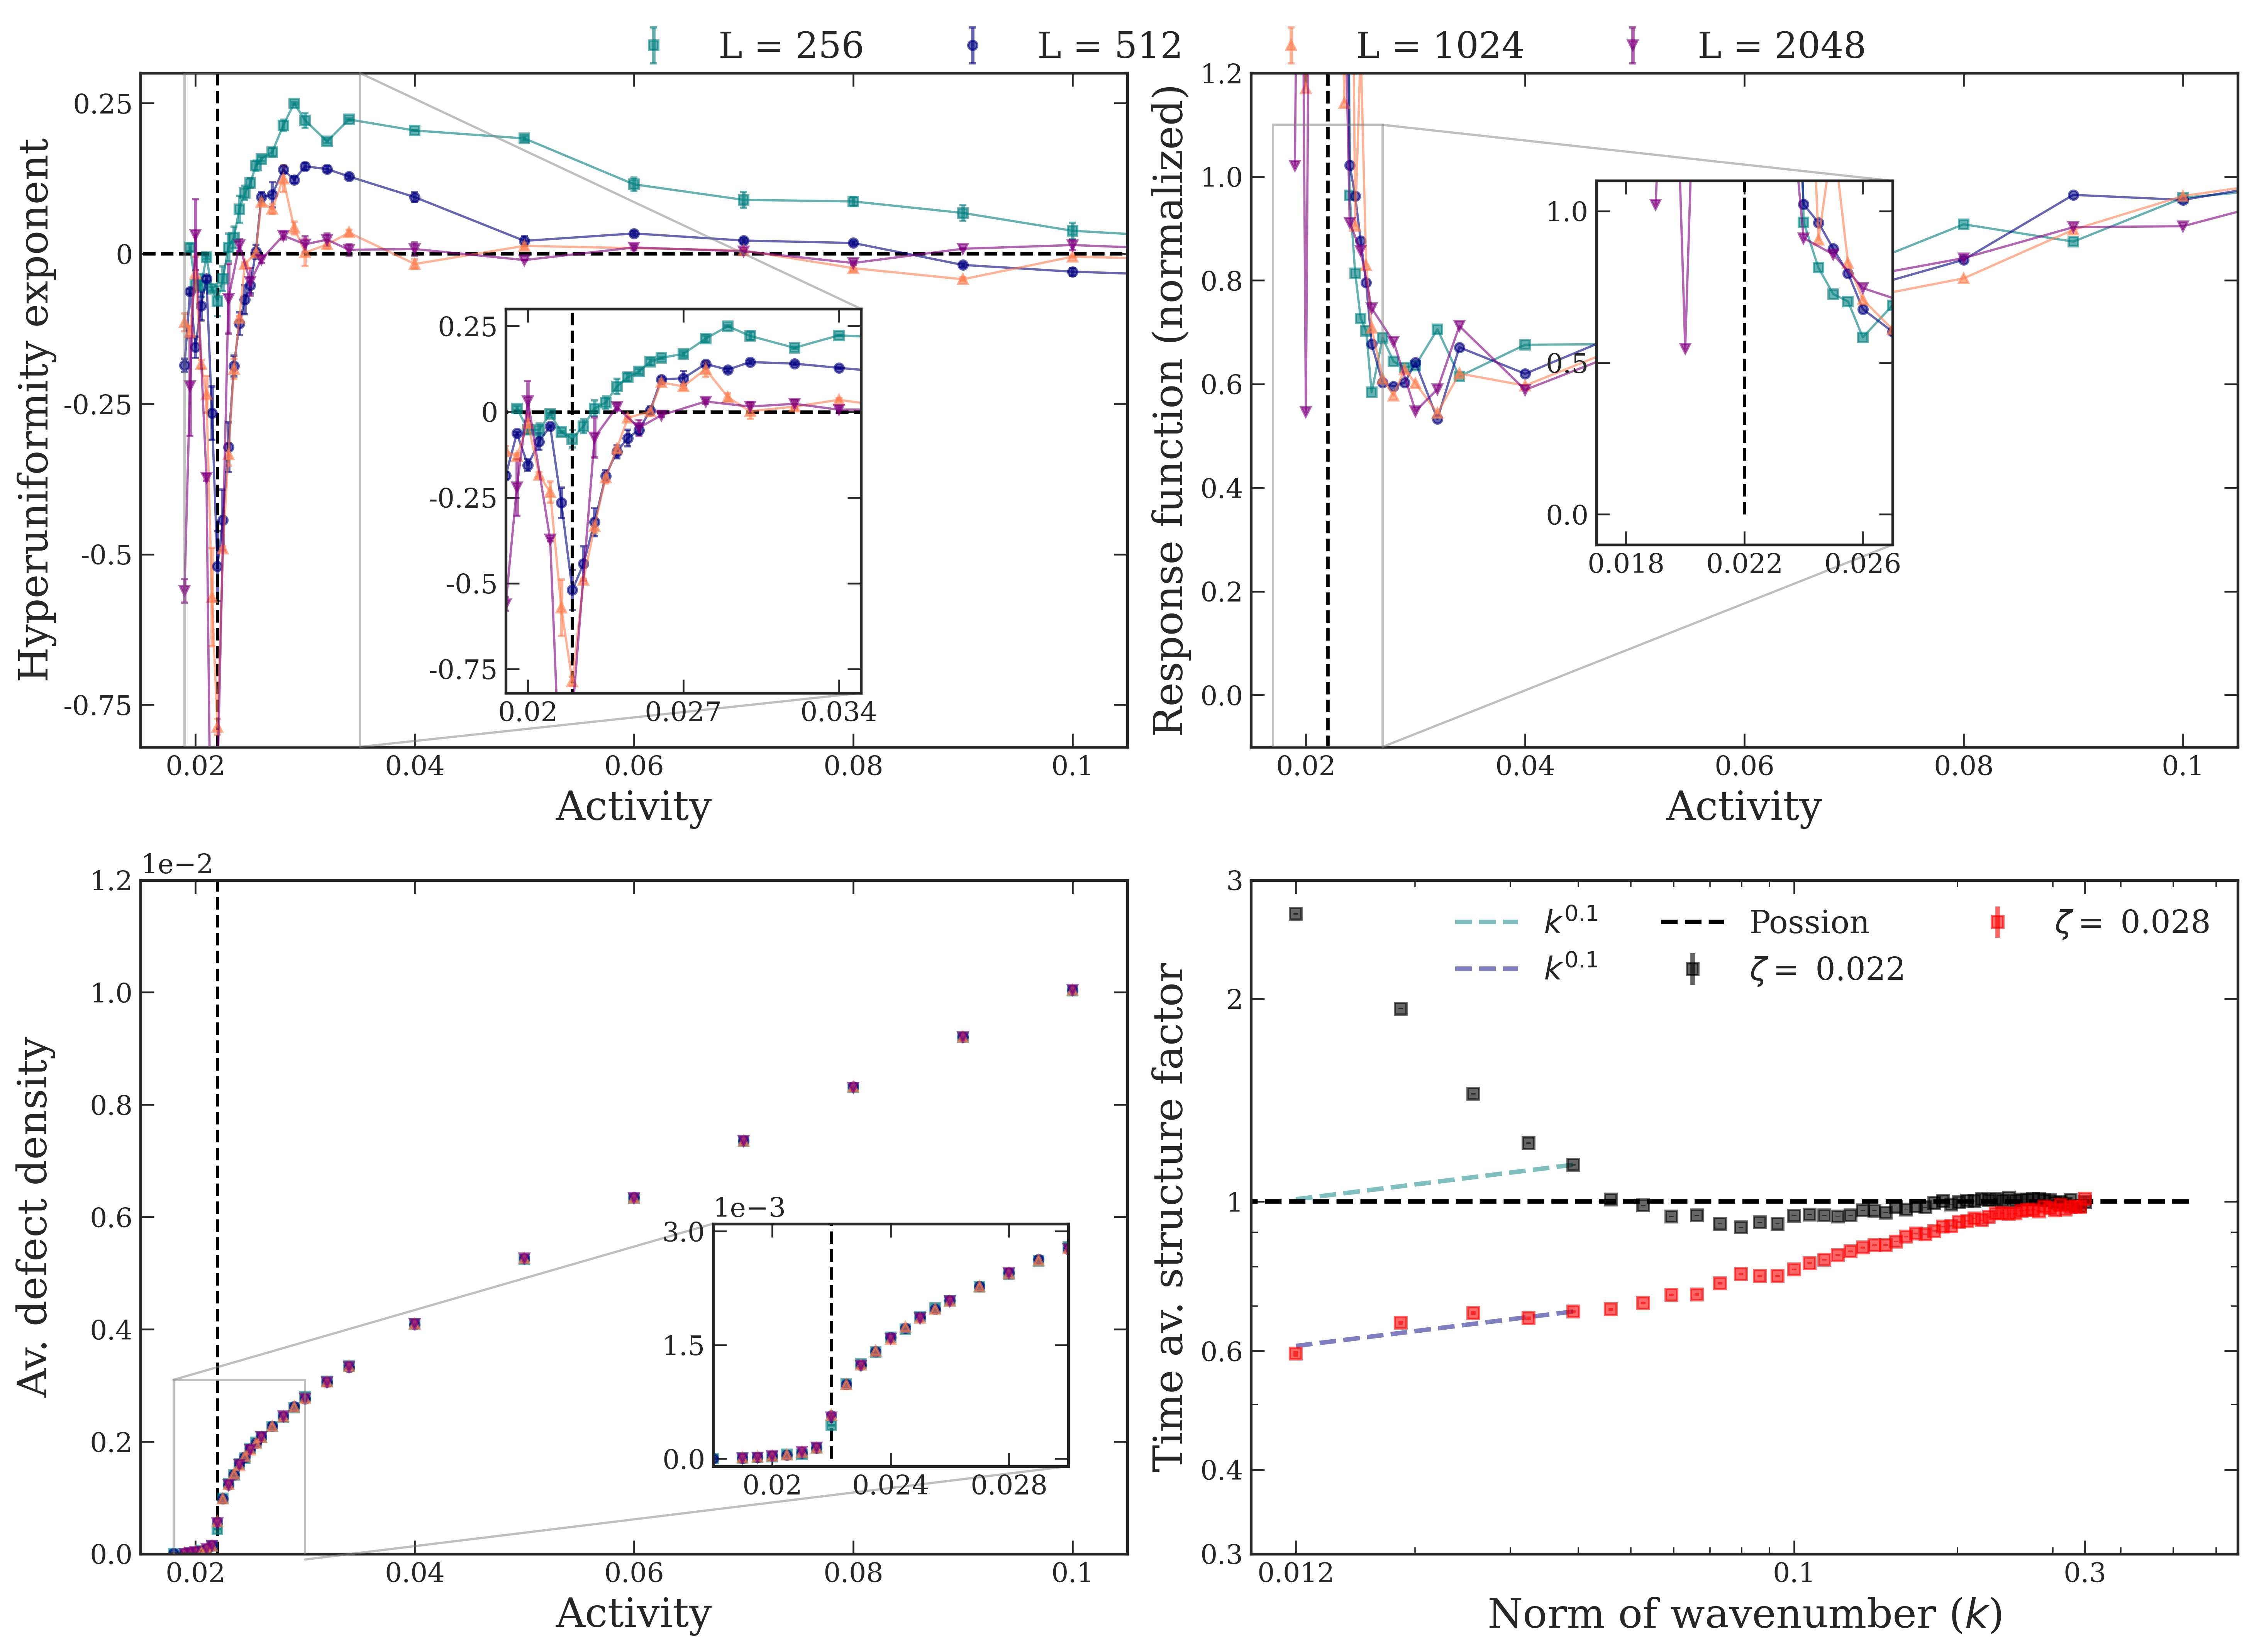

In [18]:

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(14, 10)) 
ax = ax.flatten()

peak1 = 0.022
peak2 = 0.028

xmin = 0.37
ymin = 0.08
width = 0.3
ax1, axin1 = ada.plot_alpha_mean_single(use_density_fit = True, plot_sfac=True, weighted=False, breakax = False, ax = ax[0], inset_box = [xmin, ymin,1.2*width,1.9*width])
ax2, axin2  = ada.plot_av_defects(act_bounds=[0.021, 0.024], ax=ax[2], inset_box = [0.58, 0.13, 1.2*width, 1.2*width])# inset_box = [0.28, 0.7, 0.25, 0.3])# inset_box = [0.6, 0.1, width, width], ax = ax[2])


axin1_xlims = [0.019, 0.035]
axin1_ylims = [-.82, 0.3]
ax1_xlims = [0.015, 0.105]
ax1_ylims = [-.82, 0.3]

axin2_xlims = [0.018, 0.03]
axin2_ylims = [-0.0001, 0.0031]

yticks = [-.75, -.5, -.25, 0, 0.25, 0.5]
axin1_yticks =  [-.75, -.5, -.25, 0, 0.25,]
xticks = np.round(np.linspace(ax1_xlims[0], ax1_xlims[1], 5), 2)
axin1_xticks = np.round(np.linspace(axin1_xlims[0]+0.001, axin1_xlims[1] - 0.001,3), 3)
#axin1_yticks = np.round(np.linspace(axin1_ylims[0]+.1, axin1_ylims[1] -.1,3), 3)

axin2_xticks = np.round(np.linspace(axin2_xlims[0]+0.002, axin2_xlims[1] - 0.002,3), 3)
axin2_yticks = np.round(np.linspace(axin2_ylims[0]+.0001, axin2_ylims[1] -.0001,3), 4)

ax1.set(xticks=xticks, yticks=yticks, xticklabels=xticks, yticklabels=yticks, xlim=ax1_xlims, ylim=ax1_ylims)
axin1.set(xticks=axin1_xticks, yticks=axin1_yticks, xticklabels=axin1_xticks, yticklabels=axin1_yticks, xlim=axin1_xlims, ylim=axin1_ylims)

ax1.vlines(peak1, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
axin1.vlines(peak1, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
#ax1.vlines(peak2, -1, 1, color = 'r', lw = 1.5, linestyle = '--', alpha = 1)
#axin1.vlines(peak2, -1, 1, color = 'r', lw = 1.5, linestyle = '--', alpha = 1)
ax1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
axin1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
ax1.indicate_inset_zoom(axin1,)

axin2.set(xticks=axin2_xticks, yticks=axin2_yticks, xlim=axin2_xlims, ylim=axin2_ylims, xticklabels=axin2_xticks) #, yticklabels=axin2_yticks, )
ax2.set(xticks=xticks, xticklabels=xticks,xlim=ax1_xlims, ylim=[0, 0.012])


ax2.vlines(peak1, 0, 0.02, color = 'k', lw=1.5,linestyle = '--')
#ax2.vlines(peak2, 0, 0.02, color = 'r', lw=1.5, linestyle = '--')
#axin2.vlines(peak2, 0, 0.01, color = 'r', lw=1.5, linestyle = '--')
axin2.vlines(peak1, 0, 0.01, color = 'k', lw=1.5, linestyle = '--')
ax2.indicate_inset_zoom(axin2)

ax1.set_ylabel(r'Hyperuniformity exponent', labelpad=3)
ax2.set_ylabel(r'Av. defect density', labelpad=15)
#fig.legend(ncol=4)

#ax1.axvspan(0.026, 0.030, alpha=0.2)


normalize_sus = False
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

axinn = ax[1].inset_axes([0.35, 0.3,width,1.8*width])


axinn_xlims = [0.017, 0.027]
axinn_ylims = [-.1, 1.1]
axinn_xticks = np.round(np.linspace(axinn_xlims[0]+0.001, axinn_xlims[1] - 0.001,3), 3)
axinn_yticks = np.round(np.linspace(axinn_ylims[0]+.1, axinn_ylims[1] -.1,3), 3)
axinn.set(xticks=axinn_xticks, yticks=axinn_yticks, xticklabels=axinn_xticks, yticklabels=axinn_yticks, xlim=axinn_xlims, ylim=axinn_ylims)
ax[1].indicate_inset_zoom(axinn)  
axinn.vlines(peak1, 0, 1.2, color = 'k', lw=1.5, linestyle = '--')

fig.legend(ncol=8, fontsize = 16, bbox_to_anchor=(0.84, 1.025))

ax3 = ada.plot_sfac_per_activity(LX = 1024, weighted=False, act_list=[0.022,0.028,], ax = ax[3])

if 0:
  axin3 = ax[3].inset_axes([0.35, 0.15,width,1.8*width])
  axin3_xlims = [0.017, 0.027]
  axin3_ylims = [-.1, .8]
  axin3_xticks = np.round(np.linspace(axin3_xlims[0]+0.001, axin3_xlims[1] - 0.001,3), 3)
  axin3_yticks = np.round(np.linspace(axin3_ylims[0]+.1, axin3_ylims[1] -.1,3), 3)
  axin3.set(xticks=axin3_xticks, yticks=axin3_yticks, xticklabels=axin3_xticks, yticklabels=axin3_yticks, xlim=axin3_xlims, ylim=axin3_ylims)
  ax[3].indicate_inset_zoom(axin3)
  axin3.vlines(peak1, 0, 0.01, color = 'k', lw=1.5, linestyle = '--')


for N, act_list in enumerate(ada.act_list):

        binder, sus = ada.get_binder_susceptibility(ada.LX[N])

        act_max = 0.022
        act_max_idx = act_list.index(act_max)

      #  ax[1].plot([ada.LX[N]], sus[act_max_idx], label = f'act = {act_list[act_max_idx]}', marker = 'o', color = f'C{N}')
        if normalize_sus:    
            sus = sus / sus[act_max_idx].max()
            

        reduced_act = (np.array(act_list) - act_max) / act_max
        reduced_act *= system_size_list[N] ** 2

        ax[1].plot(act_list, sus, f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)
     #   ax[3].plot(act_list, binder,  f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)
        axinn.plot(act_list, sus, f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)
      #  axin3.plot(act_list, binder,  f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)


ax[1].set_ylim(-.1,1.2)

ax3_xlims = [0.001, 0.3]
ax3_ylims = [0.3, 2.1]
ax3_xticks = np.round(np.linspace(axinn_xlims[0]+0.001, axinn_xlims[1] - 0.001,3), 3)
ax3_yticks = [0.3, 0.4, 0.6, 1, 2, 3]

ax[3].set_ylim(.3, 3)
ax[3].set(yticks=ax3_yticks,yticklabels=ax3_yticks,)
ax3_yticks = np.round(np.linspace(axinn_ylims[0]+.1, axinn_ylims[1] -.1,3), 3)
ax[1].set(xticks=xticks,xticklabels=xticks, xlim=ax1_xlims,)
#ax[3].set(xticks=ax3_xticks,xticklabels=ax3_xticks, yticks=ax3_yticks, yticklabels=ax3_yticks, xlim=ax3_xlims, ylim=ax3_ylims)
#from matplotlib.ticker import ScalarFormatter
#ax3.get_xaxis().set_major_formatter(ScalarFormatter())
#ax3.get_yaxis().set_major_formatter(ScalarFormatter())
#ax[3].text(0.1, 0.5, rf'Possibly the "order parameter" or binder cumulants v activity', transform=ax[3].transAxes, fontsize=12, verticalalignment='top')

ax1.set_xlabel(r'Activity')
ax[2].set_xlabel(r'Activity')
ax[1].set_xlabel('Activity')
ax[1].set_ylabel('Response function (normalized)')

#ax[3].set_xlabel('Activity')
#ax[3].set_ylabel('Binder Cumulant')

ax[1].vlines(peak1, -1, 1.5, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
#ax[3].vlines(peak1, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)

ax3.legend(loc = 'upper right', fontsize=14, ncol=3)
#fig.supxlabel(r'Activity')
fig.tight_layout()
fig.dpi = 420
fig.savefig('data/hyperuniformity.png', dpi = 420, pad_inches = .5)

#axin1.vlines(peak2, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)

In [68]:
def log_func(x, a, b, c):
    return a * np.log(np.abs(x * b)) + c
def linear(x, a, b):
    return a * x ** 0.5 + b

def power(x, a, b, c):
    return a * x ** b + c
def logistic_func(x, a, b, c, d, e, f):
    val = a / (1 +  np.exp(-b * (x - c))) * ( d * np.log(x) + e * x + f)
    return val
def logistic_func(x, a, b, c):
    val = a / (1 +  np.exp(-b * (x - c))) 
    return val
# do a linear fit to the average defect density



fit_string_logistic = r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} \cdot (d \ln x + ex + f)$'
fit_string_logistic = r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} $'
fit_string_log = rf'$y = a \ln (x / b) + c $'
fit_string_lin = rf'$y = a x + b$'
fit_string_power = rf'$y = a x^b + c$'
param_guess_log = np.array([0.005, 500,0.001])
param_guess_lin = np.array([0.005, 0.04])
param_guess_power = np.array([0.005, 0.5,-0.005])
param_guess_logistic = np.array([0.002, 2000, 0.023,])

fit_func = linear
param_guess = param_guess_lin
fit_string = fit_string_lin

fit_func = logistic_func
param_guess = param_guess_logistic
fit_string = fit_string_logistic

fit_func = power
param_guess = param_guess_power
fit_string = fit_string_power

fit_func = log_func
param_guess = param_guess_log
fit_string = fit_string_log

fit_func = power
param_guess = param_guess_power
fit_string = fit_string_power


fit_dict = dict(fit_func = fit_func, fit_string = fit_string, lower_act_index = 14, param_guess = param_guess)


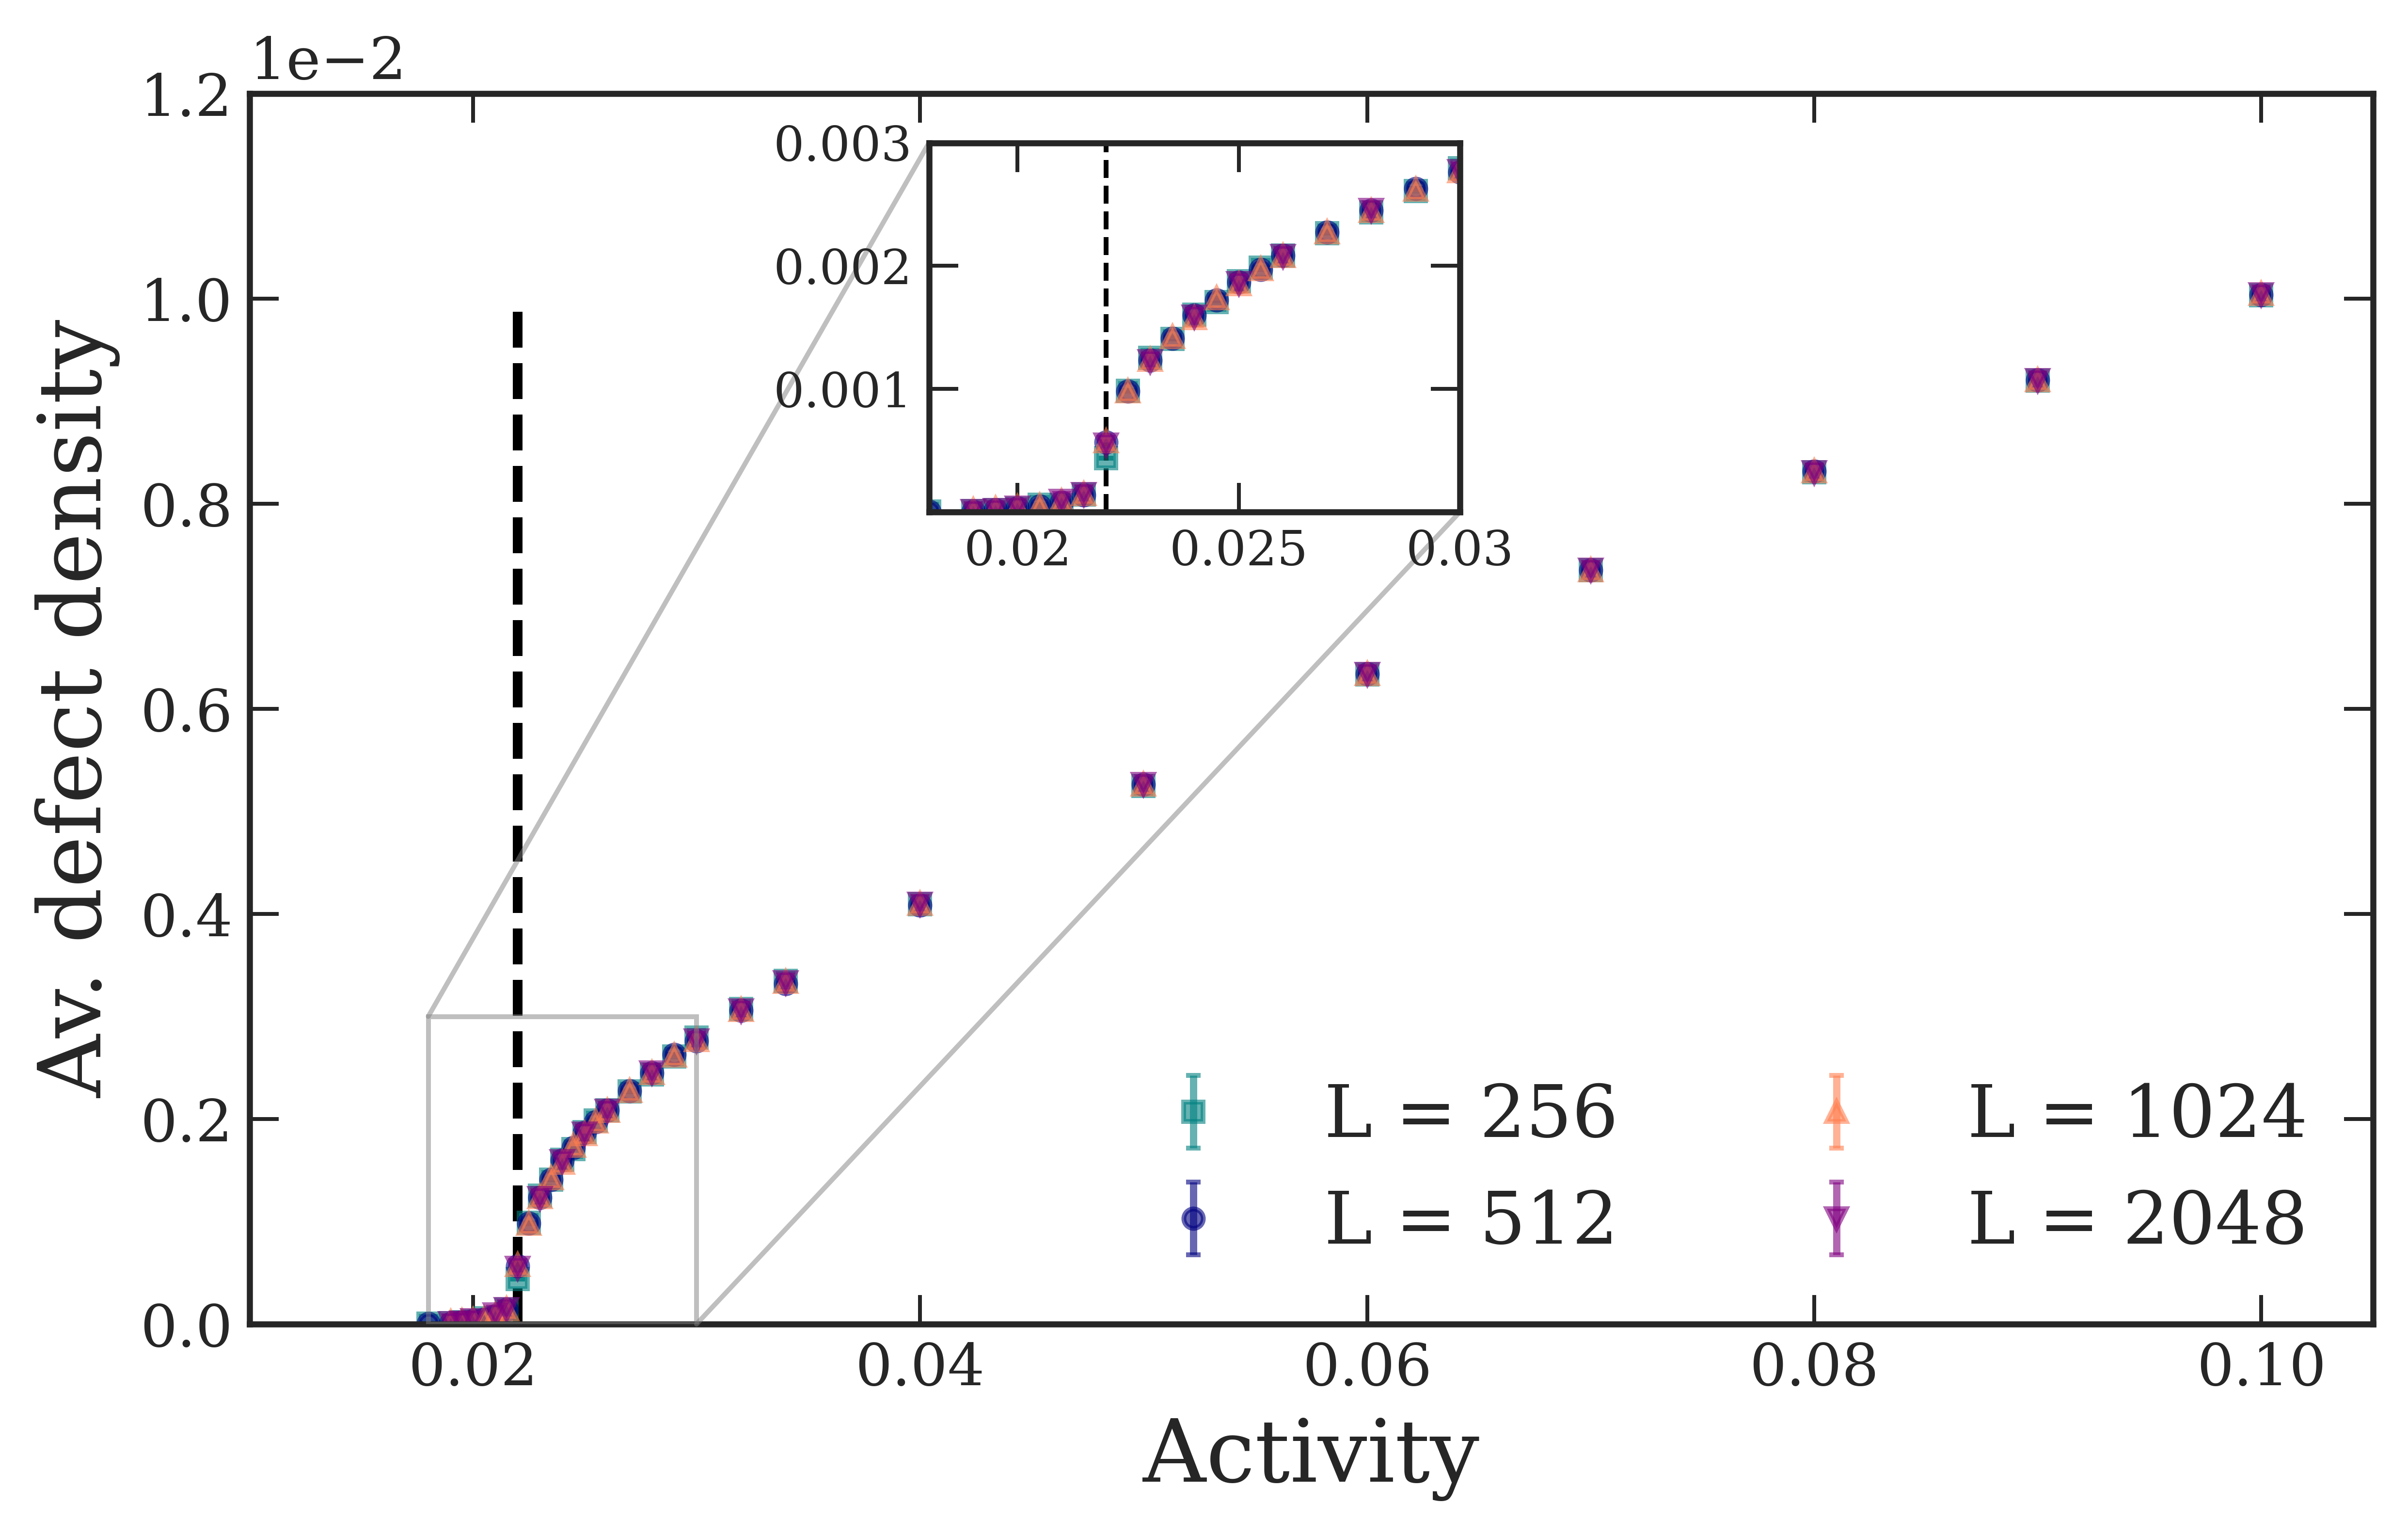

In [69]:
fig, ax, axin = ada.plot_av_defects(act_bounds=[0.021, 0.024], inset_box = [0.32, 0.66, 0.25, 0.3])


axin.set_xlim([0.018,0.03])
axin.set_ylim([0.000001, 0.003])
axin.set_xticks([0.02,0.025,0.03], [0.02,0.025,0.03], fontsize=10)
axin.set_yticks([0.001,0.002,0.003], [0.001,0.002,0.003], fontsize=10)

ax.set_xlim([0.01,0.105])
ax.set_ylim([0, 0.012])
ax.vlines(0.022, 0, 0.01, color = 'k', linestyle = '--')
#ax.vlines(0.025, 0, 0.01, color = 'k', linestyle = '--')
#ax.vlines(0.02, 0, 0.01, color = 'k', linestyle = '--')
axin.vlines(0.022, 0, 0.01, color = 'k', lw=1, linestyle = '--')
#axin.vlines(0.02225, 0, 0.01, color = 'g', linestyle = '--', lw=1)


#ax.set_ylim([0, .005])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log')
ax.legend(ncol=2, loc='lower right')

ax.indicate_inset_zoom(axin)
fig.dpi=720
fig.savefig('test.png', dpi = 720, pad_inches = .5)

NameError: name 'logistic_func' is not defined

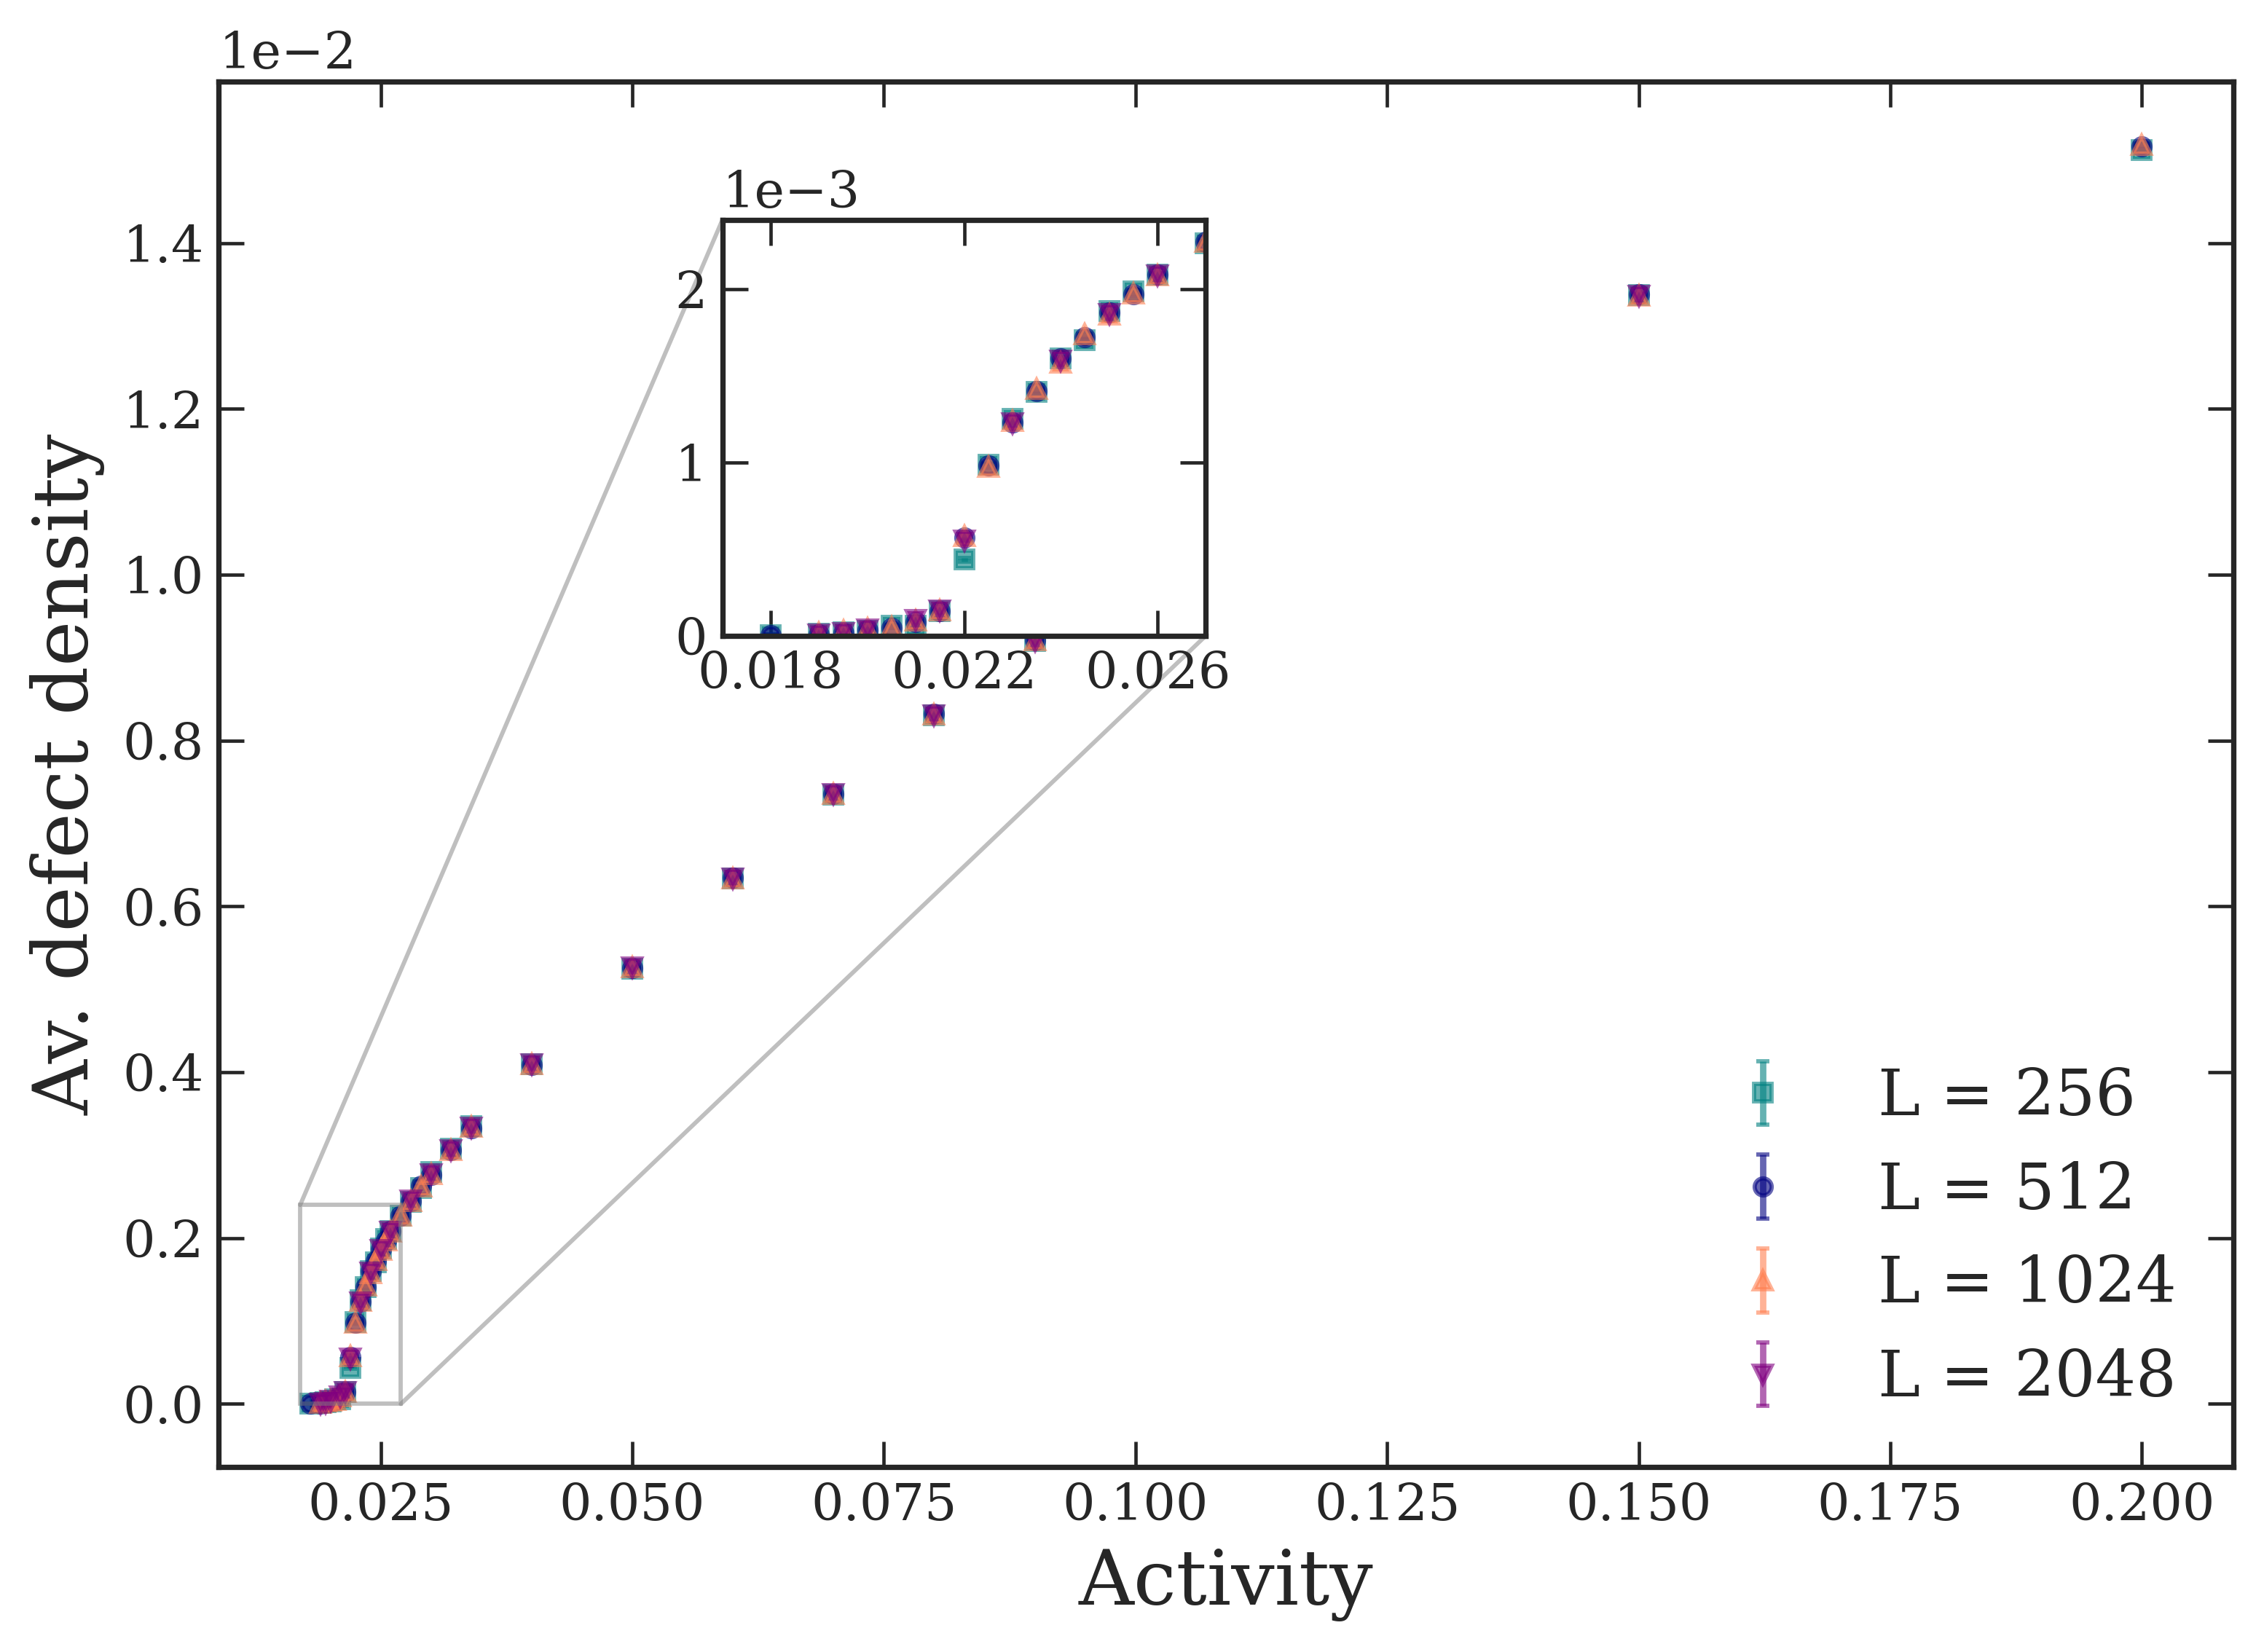

In [4]:


width = .3
inset_box = [0.25, 0.6,.8*width,1*width]

fig, ax, axin = ada.plot_av_defects(figsize=(7.5,5.5),act_bounds=[0.021, 0.024], inset_box =inset_box)#= [0.32, 0.66, 0.25, 0.3])

p_power = np.array([0.05563591932395208, 0.5925762989386102, -0.004164450175068781])
p_log = np.array([0.004958101922293866, 55.446575064673716, 0.00026152453890848973])
p_logistic = np.array([0.001622290610085664, 2324.4665041694207, 0.022408143634890017])
p_logistic = np.array([0.0017626217917815334, 1822.8633695130754, 0.02257778086582252])

#axin = ax.inset_axes([0.3, 0.64, 0.2, 0.25])
axin.set_xlim([0.017,0.027])
axin.set_ylim([0.000, 0.0024])
axin.set_xticks([0.018,0.022,0.026], [0.018,0.022,0.026])
#axin.set_yticks([5e-3, 1e-3, 1.5e-3,2e-3,2.5e-3], [5e-4, 1e-4, 1.5e-4,2e-4,2.5e-4])

ax.indicate_inset_zoom(axin)

act_list = ada.act_list[0]
act_list_power = act_list[act_list.index(0.025):]
act_list_log = np.array(act_list[act_list.index(0.025):act_list.index(0.032)])
act_list_logistic = np.array(act_list[act_list.index(0.02):act_list.index(0.025)])


fit_string_logistic = r'$y_2 = \frac{{a_2}}{{1 + e^{{-b_2(x-c_2)}}}} $'
fit_string_log = rf'$y_2 = a \ln (x / b) + c $'
fit_string_power = r'$y_1 = a_1 x^{b_1} + c_1$'

fit_string_logistic = r'$y_2$ = Logistic fit'
fit_string_power = r'$y_1 \sim \zeta^{0.6}$'

fits = []
fits += ax.plot(act_list_logistic, logistic_func(act_list_logistic, *p_logistic), '-', color=f'C7')

fits += ax.plot(act_list_power, power(act_list_power, *p_power), '-', color=f'C5')
#ax.plot(act_list_log, log_func(act_list_log, *p_log), '-', label = fit_string_log, color=f'C6')

axin.plot(act_list_power, power(act_list_power, *p_power), '-', label = fit_string_power, color=f'C5')
#axin.plot(act_list_log, log_func(act_list_log, *p_log), '-', label = fit_string_log, color=f'C6', lw=3)
axin.plot(act_list_logistic, logistic_func(act_list_logistic, *p_logistic), '-', label = fit_string_logistic, color=f'C7')



ax.set_xlim([0.01,0.105])
ax.set_ylim([0, 0.012])
#ax.vlines(0.03, 0, 0.01, color = 'k', linestyle = '--')
#ax.vlines(0.025, 0, 0.02, color = 'k',lw=1.5, linestyle = '--')
ax.vlines(0.022, 0, 0.02, color = 'k',lw=1.5, linestyle = '--')
axin.vlines(0.022, 0, 0.01, color = 'k', lw=1.5, linestyle = '--')
#axin.vlines(0.025, 0, 0.01, color = 'k',lw=1.5, linestyle = '--')
#axin.vlines(0.02225, 0, 0.01, color = 'g', linestyle = '--', lw=1)

ax.xaxis.set_minor_locator(ticker.MultipleLocator(5e-3))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1e-3))
axin.yaxis.set_minor_locator(ticker.MultipleLocator(5e-4))
axin.xaxis.set_minor_locator(ticker.MultipleLocator(1e-3))
#ax.set_ylim([0, .005])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log')
ax.axvspan(0, 0.02, facecolor='teal', alpha=0.2)#, label = 'd')
ax.axvspan(0.02, 0.025, facecolor='g', alpha=0.2)
ax.axvspan(0.025, 0.14, facecolor='grey', alpha=0.2)
axin.axvspan(0, 0.02, facecolor='teal', alpha=0.2, label = 'D')
axin.axvspan(0.02, 0.025, facecolor='g', alpha=0.2)
axin.axvspan(0.025, 0.14, facecolor='grey', alpha=0.2)

#fig.legend(ncol=2, loc='upper center')
ax.legend(ncol=2, loc='lower right')#, bbox_to_anchor=(.5, 0.9))
leg = Legend(ax, fits[:], [fit_string_logistic, fit_string_power],
             loc='upper right', frameon=False, bbox_to_anchor=(0.95, 0.96))
ax.add_artist(leg);
p_power